# Notes on current version:
For TOC if missing from command line try
jupyter nbextensions_configurator enable
then toggle nbextensions, restart.

1. 1.9.2020 Managed to convert ODE models for economic extension to transition model ready for stochastic simulation, using separate birth death list
            See section on SC2UIR model. Not done for other two economic extensions yet
2. 1.9.2020 Implemented stochastic simulation (Tau-leap method) using PyGom inbuilt capabilities: for SCIR simulation only so far
            Neeed to use integer N>>1, not 1.0, for stochastic simulation. Calculates in a few minutes for N=10000, rescaled ICUfrac to 0.02 (x10). N=100000 didn't finish in 10m.

# Model Definitions

## Utilities for custom extension of PyGom

In [8]:
# import required packages
import os 
import csv
from sympy import symbols, init_printing
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sb
from matplotlib import pyplot as plt
import sympy
import itertools
import scipy
import datetime
import matplotlib.dates as mdates
from pygom import DeterministicOde, Transition, SimulateOde, TransitionType, SquareLoss
from scipy.optimize import minimize

import pickle as pk
import jsonpickle as jpk

from cycler import cycler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pwlf

In [9]:

# This cell adds two methods to the DeterministicODE class of pygom
# dumpparams: stores params in a file './params/Model_Name.pk'
# loadparams: loads params from same file.  returns None if any problem finding the file.
# e.g. will be accessed by SCIR.dumparams() or SCIR.loadparams()
# This stuff needs modules os, sys, pickle as pk.

def dumpparams(self): # Have to add self since this will become a method
    mname = self.modelname
    dirnm = os.getcwd()
    pfile = dirnm+'/params/'+mname+'.pk'
    try:
        params = self.params.copy()
        with open(pfile,'wb') as fp:
            pk.dump(params,fp,protocol=pk.HIGHEST_PROTOCOL)
        print('dumped params to',pfile)
    except:
        print('problem dumping params to ',pfile)


def loadparams(self): # Have to add self since this will become a method
    mname = self.modelname
    dirnm = os.getcwd()
    pfile = dirnm+'/params/'+mname+'.pk'
    try:
        with open(pfile,'rb') as fp:
            params = pk.load(fp)
            print('loaded params from ',pfile,':')
    except:
        print("problem loading",pfile)
        return None


    nms = [x.name for x in self.param_list]
    try:
        self.parameters = params.copy()
        self.params = params.copy()
    except:
        print('problem loading the params; none loaded')
        return None
    return True

OdeClass = DeterministicOde().__class__
setattr(OdeClass,'dumpparams', dumpparams)
setattr(OdeClass,'loadparams', loadparams)




In [10]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn

In [11]:
def  print_ode2(self):
        '''
        Prints the ode in symbolic form onto the screen/console in actual
        symbols rather than the word of the symbol.
        
        Based on the PyGOM built-in but adapted for Jupyter
        Corrected by John McCaskill to avoid subscript format error
        '''
        A = self.get_ode_eqn()
        B = sympy.zeros(A.rows,2)
        for i in range(A.shape[0]):
            B[i,0] = sympy.symbols('d' + '{' + str(self._stateList[i]) + '}'+ '/dt=')
            B[i,1] = A[i]

        return B

In [12]:
# Jupyter Specifics
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

## Caution Extensions to SIR Model

### SIR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta I S\\
\dot{I} &= \beta I S - \gamma I - \mu I\\
\dot{R} & = \gamma I \\
\dot{D} & = \mu I
\end{split}
\end{equation}


#### Variables
* $S$: Susceptible individuals
* $I$: Infected individuals 
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+I+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [6]:
# set up the symbolic SIR model, actually SIRD including deaths

state = ['S', 'I', 'R', 'D']
param_list = ['beta', 'gamma','mu','N']

transition = [
    Transition(origin='S', destination='I', equation='beta*I*S',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='R', equation='gamma*I',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='D', equation='mu*I',
               transition_type=TransitionType.T)    
    ]

SIR_model = DeterministicOde(state, param_list, transition=transition)
SIR_model.modelname='SIR'
SIR_model.ei=1
SIR_model.confirmed=slice(1,4)  # cases 1-3 i.e. I, R and D
SIR_model.recovered=slice(2,3)
SIR_model.deaths=slice(3,4)

NameError: name 'Transition' is not defined

In [5]:
# display equations
print_ode2(SIR_model)

Matrix([
[d{S}/dt=,                 -I*S*beta],
[d{I}/dt=, I*S*beta - I*gamma - I*mu],
[d{R}/dt=,                   I*gamma],
[d{D}/dt=,                      I*mu]])

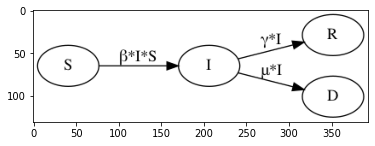

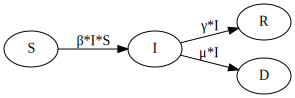

In [6]:
# display graphical representation of the model
SIR_model.get_transition_graph()

##### Derived equations, Jacobian and gradient

In [7]:
SIR_model.get_ode_eqn()

Matrix([
[                -I*S*beta],
[I*S*beta - I*gamma - I*mu],
[                  I*gamma],
[                     I*mu]])

In [8]:
SIR_model.get_jacobian_eqn()

Matrix([
[-I*beta,             -S*beta, 0, 0],
[ I*beta, S*beta - gamma - mu, 0, 0],
[      0,               gamma, 0, 0],
[      0,                  mu, 0, 0]])

In [9]:
SIR_model.get_grad_eqn()

Matrix([
[-I*S,  0,  0, 0],
[ I*S, -I, -I, 0],
[   0,  I,  0, 0],
[   0,  0,  I, 0]])

#### R0

In [9]:
from pygom.model.epi_analysis import R0

/Users/n/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sympy/__init__.py:676: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  deprecated_since_version="1.6").warn()


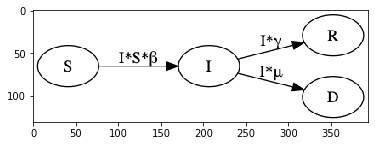

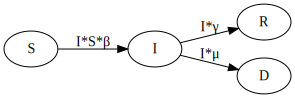

In [10]:
transition_ode = [
    Transition(origin='S',  equation='-beta*I*S'),
    Transition(origin='I',  equation='beta*I*S-gamma*I-mu*I'),
    Transition(origin='R',  equation='gamma*I'),
    Transition(origin='D',  equation='mu*I')  
    ]
ode = SimulateOde(state, param_list, ode=transition_ode)
ode = ode.get_unrolled_obj()
ode.get_transition_graph()

In [28]:
R0(ode,['I'])

0

In [29]:
import sympy.matrices.matrices
# from sympy import *

### SCIR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta I S + c_1 S_c - c_2*S*I\\
\dot{S_c} &= - c_0 \beta I S_c - c_1 S_c + c_2*S*I\\
\dot{I} &= \beta I S - \gamma I - \mu I\\
\dot{R} & = \gamma I \\
\dot{D} & = \mu I
\end{split}
\end{equation}

The use of I as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one. Alternatively, one could use the daily death rate which is proportional to it.

Actually, the effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. The current version assumes that infectives do not change their precautionary measures in response to I. To implement this we would need to further distinguish careful and non careful infectives. This is done in the SC2IR model.

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $I$: Infected individuals 
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+I+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [ ]:
# set up symbolic model

state = ['S', 'I', 'R', 'D', 'S_c']
param_list = ['beta', 'gamma', 'mu', 'c_0', 'c_1', 'c_2', 'N']

transition = [
    Transition(origin='S', destination='I', equation='beta*I*S',
               transition_type=TransitionType.T),
    Transition(origin='S', destination='S_c', equation='c_2*I*S',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='S', equation='c_1*S_c',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='I', equation='c_0*beta*I*S_c',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='R', equation='gamma*I',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='D', equation='mu*I',
               transition_type=TransitionType.T)    
    ]

SCIR_model = DeterministicOde(state, param_list, transition=transition)

SCIR_modelS = SimulateOde(state, param_list , transition=transition)
SCIR_model.modelname='SCIR'
SCIR_model.ei=1
SCIR_model.confirmed=slice(1,4)  # cases 1-3 i.e. I, R and D
SCIR_model.recovered=slice(2,3)
SCIR_model.deaths=slice(3,4)




In [65]:
# display equations
print_ode2(SCIR_model)

Matrix([
[  d{S}/dt=,              -I*S*beta - I*S*c_2 + S_c*c_1],
[  d{I}/dt=, I*S*beta + I*S_c*beta*c_0 - I*gamma - I*mu],
[  d{R}/dt=,                                    I*gamma],
[  d{D}/dt=,                                       I*mu],
[d{S_c}/dt=,         I*S*c_2 - I*S_c*beta*c_0 - S_c*c_1]])

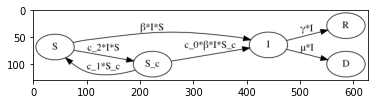

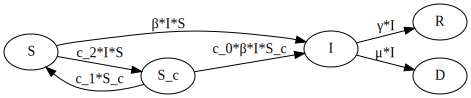

In [66]:
# display graphical representation of the model
SCIR_model.get_transition_graph()

### SC2IR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta (I + c_0 I_c) S + c_1 S_c - c_2 S (I + I_c)\\
\dot{S_c} &= - c_0 \beta (I + c_0 I_c) S_c - c_1 S_c + c_2 S (I + I_c)\\
\dot{I} &= \beta (I + c_0 I_c) S - \gamma I - \mu I + c_1 I_c - c_2 I (I + I_c)\\
\dot{I_c} &= \beta (I + c_0 I_c) S_c - \gamma I_c - \mu I_c - c_1 I_c + c_2 I (I + I_c)\\
\dot{R} & = \gamma (I + I_c)\\
\dot{D} & = \mu (I + I_c)
\end{split}
\end{equation}

The use of I as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one. Alternatively, one could use the daily death rate which is proportional to it.

The effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. To implement this we distinguish careful and non careful infectives. We ignore infectives making the transition to caution or relaxing it.

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $I$: Infected individuals non exercising pandemy precautions
* $I_c$: Infected individuals exercising pandemy precautions 
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+I+I_c+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [ ]:
# set up symbolic model

state = ['S', 'I', 'R', 'D', 'I_c', 'S_c']
param_list = ['beta', 'gamma', 'mu', 'c_0', 'c_1', 'c_2', 'N']

transition = [
    Transition(origin='S', destination='I', equation='beta*(I+c_0*I_c)*S',
               transition_type=TransitionType.T),
    Transition(origin='S', destination='S_c', equation='c_2*(I+I_c)*S',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='S', equation='c_1*S_c',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='I_c', equation='c_0*beta*(I+c_0*I_c)*S_c',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='R', equation='gamma*I',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='D', equation='mu*I',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='I_c', equation='c_2*(I+I_c)*I',
               transition_type=TransitionType.T),
    Transition(origin='I_c', destination='R', equation='gamma*I_c',
               transition_type=TransitionType.T),
    Transition(origin='I_c', destination='I', equation='c_1*I_c',
               transition_type=TransitionType.T),
    Transition(origin='I_c', destination='D', equation='mu*I_c',
               transition_type=TransitionType.T)  #, 
    ]

SC2IR_model = DeterministicOde(state, param_list, transition=transition)
SC2IR_model.modelname='SC2IR'

SC2IR_model.ei=1
SC2IR_model.confirmed=slice(1,5)  # cases 1-3 i.e. I, R and D
SC2IR_model.recovered=slice(2,3)
SC2IR_model.deaths=slice(3,4)

In [38]:
# display equations
print_ode2(SC2IR_model)

Matrix([
[  d{S}/dt=,                           -S*beta*(I + I_c*c_0) - S*c_2*(I + I_c) + S_c*c_1],
[  d{I}/dt=,          -I*c_2*(I + I_c) - I*gamma - I*mu + I_c*c_1 + S*beta*(I + I_c*c_0)],
[  d{R}/dt=,                                                         I*gamma + I_c*gamma],
[  d{D}/dt=,                                                               I*mu + I_c*mu],
[d{I_c}/dt=, I*c_2*(I + I_c) - I_c*c_1 - I_c*gamma - I_c*mu + S_c*beta*c_0*(I + I_c*c_0)],
[d{S_c}/dt=,                      S*c_2*(I + I_c) - S_c*beta*c_0*(I + I_c*c_0) - S_c*c_1]])


\begin{equation}
\begin{split}
\dot{S} &= -\beta (I + c_0 I_c) S + c_1 S_c - c_2 S (I + I_c)\\
\dot{S_c} &= - c_0 \beta (I + c_0 I_c) S_c - c_1 S_c + c_2 S (I + I_c)\\
\dot{I} &= \beta (I + c_0 I_c) S - \gamma I - \mu I\\
\dot{I_c} &= \beta (I + c_0 I_c) S_c - \gamma I_c - \mu I_c\\
\dot{R} & = \gamma (I + I_c)\\
\dot{D} & = \mu (I + I_c)
\end{split}
\end{equation}


In [ ]:
# display graphical representation of the model
SC2IR_model.get_transition_graph()

## Caution Extensions to SEIR Model

### SEIR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta I S\\
\dot{E} &= \beta I S - \alpha E\\
\dot{I} &= \alpha E - \gamma I - \mu I\\
\dot{R} & = \gamma I \\
\dot{D} & = \mu I
\end{split}
\end{equation}


#### Variables
* $S$: Susceptible individuals
* $E$: Exposed individuals
* $I$: Infected individuals 
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+E+I+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and expose them to infection
* $\alpha$ rate at which exposed individuals become infected (1/(incubation time)
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [ ]:
# set up the symbolic model
state = ['S', 'E', 'I', 'R', 'D']
param_list = ['beta', 'alpha', 'gamma', 'mu', 'N']

transition = [
    Transition(origin='S', destination='E', equation='beta*I*S',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='I', equation='alpha*E',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='R', equation='gamma*I',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='D', equation='mu*I',
               transition_type=TransitionType.T)    
    ]

SEIR_model = DeterministicOde(state, param_list, transition=transition)
SEIR_model.modelname='SEIR'
SEIR_model.ei=slice(1,3) # cases 1,2 i.e. E and I
SEIR_model.confirmed=slice(2,5)  # cases 2-4 i.e. I, R and D, not E
SEIR_model.recovered=slice(3,4)
SEIR_model.deaths=slice(4,5)


In [ ]:
# display equations
print_ode2(SEIR_model)

In [ ]:
# display graphical representation of the model
SEIR_model.get_transition_graph()

### SCEIR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta I S + c_1 S_c - c_2*S*I\\
\dot{S_c} &= - c_0 \beta I S_c - c_1 S_c + c_2*S*I\\
\dot{E} &= \beta I (S + c_0 S_c) - \alpha E\\
\dot{I} &= \alpha E - \gamma I - \mu I\\
\dot{R} & = \gamma I \\
\dot{D} & = \mu I
\end{split}
\end{equation}

The use of I as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one. Alternatively, one could use the daily death rate which is proportional to it.

Actually, the effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. The current version assumes that infectives do not change their precautionary measures in response to I. To implement this we would need to further distinguish careful and non careful infectives. This is done in the SC2IR model.

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $E$: Exposed individuals
* $I$: Infected individuals 
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+E+I+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\alpha$ rate at which exposed individuals become infected (1/(incubation time)
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [ ]:
# set up the symbolic model

state = ['S', 'E', 'I', 'R', 'D', 'S_c']
param_list = ['beta', 'alpha', 'gamma', 'mu', 'c_0', 'c_1', 'c_2', 'N']

transition = [
    Transition(origin='S', destination='E', equation='beta*I*S',
               transition_type=TransitionType.T),
    Transition(origin='S', destination='S_c', equation='c_2*I*S',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='S', equation='c_1*S_c',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='E', equation='c_0*beta*I*S_c',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='I', equation='alpha*E',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='R', equation='gamma*I',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='D', equation='mu*I',
               transition_type=TransitionType.T)    
    ]

SCEIR_model = DeterministicOde(state, param_list, transition=transition)
SCEIR_model.modelname='SCEIR'
SCEIR_model.ei=slice(1,3) # cases 1,2 i.e. E,I
SCEIR_model.confirmed=slice(2,5)  # cases 2-4 i.e. I, R and D, not E
SCEIR_model.recovered=slice(3,4)
SCEIR_model.deaths=slice(4,5)

In [ ]:
# display equations
print_ode2(SCEIR_model)

In [ ]:
# display graphical representation of the model
SCEIR_model.get_transition_graph()

### SC3EIR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta (I + c_0 I_c) S + c_1 S_c - c_2 S (I + I_c)\\
\dot{S_c} &= - c_0 \beta (I + c_0 I_c) S_c - c_1 S_c + c_2 S (I + I_c)\\
\dot{E} &= \beta (I + c_0 I_c) S - \alpha E  + c_1 E_c - c_2 E (I + I_c)\\
\dot{E_c} &= c_0 \beta (I + c_0 I_c) S_c - \alpha E_c  - c_1 E_c + c_2 E (I + I_c)\\
\dot{I} &= \alpha E - \gamma I - \mu I  + c_1 I_c - c_2 I (I + I_c)\\
\dot{I_c} &= \alpha E_c - \gamma I_c - \mu I_c - c_1 I_c + c_2 I (I + I_c)\\
\dot{R} & = \gamma (I + I_c) \\
\dot{D} & = \mu (I + I_c)
\end{split}
\end{equation}

The use of I as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one. Alternatively, one could use the daily death rate which is proportional to it.

Actually, the effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. The current version assumes that infectives do not change their precautionary measures in response to I. To implement this we would need to further distinguish careful and non careful infectives. This is done in the SC2IR model.

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $E$: Exposed individuals
* $E_c$: Exposed individuals exercising caution
* $I$: Infected individuals
* $I_c$: Infected individuals exercising caution
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+E+E_c+I+I_c+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\alpha$ rate at which exposed individuals become infected (1/(incubation time)
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [ ]:
# set up the symbolic model

state = ['S', 'E', 'I', 'R', 'D', 'I_c', 'S_c', 'E_c']
param_list = ['beta', 'alpha', 'gamma', 'mu', 'c_0', 'c_1', 'c_2', 'N']

transition = [
    Transition(origin='S', destination='E', equation='beta*(I+c_0*I_c)*S',
               transition_type=TransitionType.T),
    Transition(origin='S', destination='S_c', equation='c_2*(I+I_c)*S',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='S', equation='c_1*S_c',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='E_c', equation='c_0*beta*(I+c_0*I_c)*S_c',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='I', equation='alpha*E',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='E_c', equation='c_2*(I+I_c)*E',
               transition_type=TransitionType.T),
    Transition(origin='E_c', destination='I_c', equation='alpha*E_c',
               transition_type=TransitionType.T),
    Transition(origin='E_c', destination='E', equation='c_1*E_c',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='R', equation='gamma*I',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='I_c', equation='c_2*(I+I_c)*I',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='D', equation='mu*I',
               transition_type=TransitionType.T),
    Transition(origin='I_c', destination='R', equation='gamma*I_c',
               transition_type=TransitionType.T),
    Transition(origin='I_c', destination='I', equation='c_1*I_c',
               transition_type=TransitionType.T),
    Transition(origin='I_c', destination='D', equation='mu*I_c',
               transition_type=TransitionType.T)
    ]

SC3EIR_model = DeterministicOde(state, param_list, transition=transition)
SC3EIR_model.modelname='SC3EIR'
SC3EIR_model.ei=slice(1,3) # cases 1,2 i.e. E,I  # note E_c and I_c not included
SC3EIR_model.confirmed=slice(2,6)  # cases 2-5 i.e. I, R, D, and I_c, not E, E_c
SC3EIR_model.recovered=slice(3,4)
SC3EIR_model.deaths=slice(4,5)

In [ ]:
# display equations
print_ode2(SC3EIR_model)

In [ ]:
# display graphical representation of the model
SC3EIR_model.get_transition_graph()

## Caution Extensions to SEI3R Model

### SEI3R model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3) S\\
\dot{E} &=(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3 ) S - a E \\
\dot{I_1} &= a E - \gamma_1 I_1 - p_1 I_1 \\
\dot{I_2} &= p_1 I_1 -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\
\dot{R} & = \gamma_1 I_1 + \gamma_2 I_2 + \gamma_3 I_3 \\
\dot{D} & = \mu I_3
\end{split}
\end{equation}

This model (by Dr. Alison for example) involves exposed but not infectious individuals and three classes of infective states with increasing severity.
The latter two involve hospitalization with the last in ICU.

#### Variables
* $S$: Susceptible individuals living as normal
* $E$: Exposed individuals - infected but not yet infectious or symptomatic
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes
  * $I_1$: Mild infection (hospitalization not required)
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+E+I_1+I_2+I_3+R+D$ Total population size (constant)

#### Parameters
* $\beta_i$ rate at which infected individuals in class $I_i$ contact susceptibles and infect them
* $a$ rate of progression from the exposed to infected class
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $\mu$ death rate for individuals in the most severe stage of disease

#### Implementation
Using PyGOM, we will set up the model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [ ]:
# set up the symbolic SEI3R model

state = ['S', 'E', 'I_1', 'I_2','I_3','R','D']
param_list = ['beta_1', 'beta_2','beta_3','alpha', 'gamma_1', 'gamma_2', 'gamma_3',
              'p_1','p_2','mu','N']

transition = [
    Transition(origin='S', destination='E', equation='(beta_1*I_1+beta_2*I_2+beta_3*I_3)*S',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='I_1', equation='alpha*E',
               transition_type=TransitionType.T),
    Transition(origin='I_1', destination='R', equation='gamma_1*I_1',
               transition_type=TransitionType.T),
    Transition(origin='I_2', destination='R', equation='gamma_2*I_2',
               transition_type=TransitionType.T),
    Transition(origin='I_3', destination='R', equation='gamma_3*I_3',
               transition_type=TransitionType.T),
    Transition(origin='I_1', destination='I_2', equation='p_1*I_1',
               transition_type=TransitionType.T),
    Transition(origin='I_2', destination='I_3', equation='p_2*I_2',
               transition_type=TransitionType.T),
    Transition(origin='I_3', destination='D', equation='mu*I_3',
               transition_type=TransitionType.T)    
    ]


SEI3R_model = DeterministicOde(state, param_list, transition=transition)
SEI3R_model.modelname='SEI3R'
SEI3R_model.ei=slice(1,5)
SEI3R_model.confirmed=slice(2,7)  # cases 2-6 i.e. I1, I2, I3, R and D
SEI3R_model.recovered=slice(5,6)
SEI3R_model.deaths=slice(6,7)

In [ ]:
# display equations
print_ode2(SEI3R_model)

In [ ]:
# display graphical representation of the model
SEI3R_model.get_transition_graph()

### SCEI3R model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3) S + c_1 S_c - c_2*S*I_3\\
\dot{S_c} &= - c_0(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3) S_c - c_1 S_c + c_2*S*I_3\\
\dot{E} &=(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3 ) (S + c_0 S_c) - a E \\
\dot{I_1} &= a E - \gamma_1 I_1 - p_1 I_1 \\
\dot{I_2} &= p_1 I_1 -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\
\dot{R} & = \gamma_1 I_1 + \gamma_2 I_2 + \gamma_3 I_3 \\
\dot{D} & = \mu I_3
\end{split}
\end{equation}

The use of I_3 as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one.

Actually, the effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. The current version assumes that infectives do not change their precautionary measures in response to I_3. To implement this we would need to further distinguish careful and non careful infectives at least up to the I_1 level. This is done in the SC3EI3R model.

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $E$: Exposed individuals - infected but not yet infectious or symptomatic
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes
  * $I_1$: Mild infection (hospitalization not required)
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+E+I_1+I_2+I_3+R+D$ Total population size (constant)

#### Parameters
* $\beta_i$ rate at which infected individuals in class $I_i$ contact susceptibles and infect them
* $a$ rate of progression from the exposed to infected class
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $\mu$ death rate for individuals in the most severe stage of disease

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible




#### Implementation
Using PyGOM, we will set up the model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [ ]:
# set up the symbolic model

state = ['S', 'E', 'I_1', 'I_2','I_3','R','D','S_c']
param_list = ['beta_1', 'beta_2','beta_3','alpha', 'gamma_1', 'gamma_2', 'gamma_3',
              'p_1','p_2','mu','c_0','c_1','c_2','N']

transition = [
    Transition(origin='S', destination='E', equation='(beta_1*I_1+beta_2*I_2+beta_3*I_3)*S',
               transition_type=TransitionType.T),
    Transition(origin='S', destination='S_c', equation='c_2*I_3*S',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='S', equation='c_1*S_c',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='E', equation='c_0*(beta_1*I_1+beta_2*I_2+beta_3*I_3)*S_c',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='I_1', equation='alpha*E',
               transition_type=TransitionType.T),
    Transition(origin='I_1', destination='R', equation='gamma_1*I_1',
               transition_type=TransitionType.T),
    Transition(origin='I_2', destination='R', equation='gamma_2*I_2',
               transition_type=TransitionType.T),
    Transition(origin='I_3', destination='R', equation='gamma_3*I_3',
               transition_type=TransitionType.T),
    Transition(origin='I_1', destination='I_2', equation='p_1*I_1',
               transition_type=TransitionType.T),
    Transition(origin='I_2', destination='I_3', equation='p_2*I_2',
               transition_type=TransitionType.T),
    Transition(origin='I_3', destination='D', equation='mu*I_3',
               transition_type=TransitionType.T)    
    ]


SCEI3R_model = DeterministicOde(state, param_list, transition=transition)
SCEI3R_model.modelname='SCEI3R'
SCEI3R_model.ei=slice(1,5)
SCEI3R_model.confirmed=slice(2,7)  # cases 2-6 i.e. I1, I2, I3, R and D
SCEI3R_model.recovered=slice(5,6)
SCEI3R_model.deaths=slice(6,7)

In [ ]:
# display equations
print_ode2(SCEI3R_model)

In [ ]:
# display graphical representation of the model
SCEI3R_model.get_transition_graph()

### SC3EI3R model with caution distinguished $E$ and  𝐼1

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3) S + c_1 S_c - c_2*S*I_3\\
\dot{S_c} &= - c_0(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3) S_c - c_1 S_c + c_2*S*I_3\\
\dot{E} &=(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3 ) S - a E + c_1 E_c - c_2*E*I_3\\
\dot{E_c} &=(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3 ) c_0 S_c - a E - c_1 E_c + c_2*E*I_3\\
\dot{I_1} &= a E - \gamma_1 I_1 - p_1 I_1 + c_1 I_{1c} - c_2*I_{1c}*I_3\\
\dot{I_{1c}} &= a E_c - \gamma_1 I_{1c} - p_1 I_{1c} - c_1 I_{1c} + c_2*I_{1c}*I_3\\
\dot{I_2} &= p_1 (I_1 + I_{1c}) -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\
\dot{R} & = \gamma_1 (I_1 + I_{1c}) + \gamma_2 I_2 + \gamma_3 I_3 \\
\dot{D} & = \mu I_3
\end{split}
\end{equation}

The use of I_3 as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one.

Here, the effect of caution is quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. To implement this we distinguish careful and non careful exposed and infectives up to the I_1 level. Once in hospital there is no difference, since all caution is executed wrt infected patients.
We ignore transition in caution among infected intervals as a second order effect: could be included as in SC2IR model.


#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $E$: Exposed individuals living as normal - infected but not yet infectious or symptomatic
* $E_c$: Exposed individuals exercising pandemy precautions
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes. Split non hospital cases by caution.
  * $I_1$: Mild infection (hospitalization not required), living as normal
  * $I_{1c}$: Mild infection (hospitalization not required), exercising caution
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+E+E_c+I_{1c}+I_1+I_2+I_3+R+D$ Total population size (constant)

#### Parameters
* $\beta_i$ rate at which infected individuals in class $I_i$ contact susceptibles and infect them
* $a$ rate of progression from the exposed to infected class
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $\mu$ death rate for individuals in the most severe stage of disease

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

####  Implementation

In [ ]:
# set up the symbolic model

state = ['S', 'E', 'I_1', 'I_2','I_3', 'R', 'D', 'I_c', 'S_c', 'E_c']
param_list = ['beta_1', 'beta_2','beta_3','alpha', 'gamma_1', 'gamma_2', 'gamma_3',
              'p_1','p_2','mu','c_0','c_1','c_2','N']

transition = [
    Transition(origin='S', destination='E', equation='(beta_1*I_1+beta_2*I_2+beta_3*I_3+c_0*beta_1*I_c)*S',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='E_c', equation='c_0*(beta_1*I_1+beta_2*I_2+beta_3*I_3+c_0*beta_1*I_c)*S_c',
               transition_type=TransitionType.T),
    Transition(origin='S', destination='S_c', equation='c_2*I_3*S',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='S', equation='c_1*S_c',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='I_1', equation='alpha*E',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='E_c', equation='c_2*I_3*E',
               transition_type=TransitionType.T),
    Transition(origin='E_c', destination='I_c', equation='alpha*E_c',
               transition_type=TransitionType.T),
    Transition(origin='E_c', destination='E', equation='c_1*E_c',
               transition_type=TransitionType.T),
    Transition(origin='I_1', destination='R', equation='gamma_1*I_1',
               transition_type=TransitionType.T),
    Transition(origin='I_1', destination='I_c', equation='c_2*I_3*I_1',  # error corrected I_1, mistakenly was I_c 
               transition_type=TransitionType.T),    
    Transition(origin='I_c', destination='R', equation='gamma_1*I_c',
               transition_type=TransitionType.T),
    Transition(origin='I_c', destination='I_1', equation='c_1*I_c',
               transition_type=TransitionType.T),    
    Transition(origin='I_2', destination='R', equation='gamma_2*I_2',
               transition_type=TransitionType.T),
    Transition(origin='I_3', destination='R', equation='gamma_3*I_3',
               transition_type=TransitionType.T),
    Transition(origin='I_1', destination='I_2', equation='p_1*I_1',
               transition_type=TransitionType.T),
    Transition(origin='I_c', destination='I_2', equation='p_1*I_c',
               transition_type=TransitionType.T),
    Transition(origin='I_2', destination='I_3', equation='p_2*I_2',
               transition_type=TransitionType.T),
    Transition(origin='I_3', destination='D', equation='mu*I_3',
               transition_type=TransitionType.T)
    ]


SC3EI3R_model = DeterministicOde(state, param_list, transition=transition)
SC3EI3R_model.modelname='SC3EI3R'
SC3EI3R_model.ei=slice(1,5) # 1,2,3,4 i.e. E,I_1,I_2,I_3 – not E_c and I_c 
SC3EI3R_model.confirmed=slice(2,8)  # cases 2-7 i.e. I1, I2, I3, R, D and I_c
SC3EI3R_model.recovered=slice(5,6)
SC3EI3R_model.deaths=slice(6,7)

In [ ]:
# display equations
print_ode2(SC3EI3R_model)

In [ ]:
# display graphical representation of the model
SC3EI3R_model.get_transition_graph()

In [19]:
# set up the symbolic model directly as ODEs to allow confirmed cases as state for fitting

state = ['S', 'E', 'I_1', 'I_2','I_3', 'R', 'D', 'I_c', 'S_c', 'E_c', 'C_f']
param_list = ['beta_1', 'beta_2','beta_3','alpha', 'gamma_1', 'gamma_2', 'gamma_3',
              'p_1','p_2','mu','c_0','c_1','c_2','N']

transition = [
    Transition('S', '-(beta_1*(I_1+c_0*I_c)+beta_2*I_2+beta_3*I_3)*S - c_2*I_3*S + c_1*S_c','ODE'),
    Transition('S_c', '-c_0*(beta_1*(I_1+c_0*I_c)+beta_2*I_2+beta_3*I_3)*S_c+c_2*I_3*S-c_1*S_c','ODE'),
    Transition('E', '(beta_1*(I_1+c_0*I_c)+beta_2*I_2+beta_3*I_3)*S-alpha*E-c_2*I_3*E+c_1*E_c','ODE'),
    Transition('E_c', 'c_0*(beta_1*(I_1+c_0*I_c)+beta_2*I_2+beta_3*I_3)*S_c-alpha*E_c+c_2*I_3*E-c_1*E_c','ODE'),
    Transition('I_1', 'alpha*E-gamma_1*I_1-p_1*I_1-c_2*I_3*I_1+c_1*I_c','ODE'),
    Transition('I_c', 'alpha*E_c-gamma_1*I_c-p_1*I_c+c_2*I_3*I_1-c_1*I_c','ODE'),
    Transition('I_2', 'p_1*(I_1+I_c)-gamma_2*I_2-p_2*I_2','ODE'),
    Transition('I_3', 'p_2*I_2-gamma_3*I_3-mu*I_3','ODE'),
    Transition('R',  'gamma_1*(I_1+I_c)+gamma_2*I_2+gamma_3*I_3','ODE'),
    Transition('D',  'mu*I_3','ODE'),
    Transition('C_f', 'alpha*(E+E_c)','ODE')
    ]

SC3EI3R_model = DeterministicOde(state, param_list, ode=transition)
SC3EI3R_model.modelname='SC3EI3R'
SC3EI3R_model.ei=slice(1,5) # 1,2,3,4 i.e. E,I_1,I_2,I_3 – not E_c and I_c 
SC3EI3R_model.confirmed=slice(10,11)
SC3EI3R_model.recovered=slice(5,6)
SC3EI3R_model.deaths=slice(6,7)

In [ ]:
# display equations
print_ode2(SC3EI3R_model)

## Caution Extensions to SEIR Model with Economic Supression
This model is an extension of the cautionary model to include a class of susceptibles $S_u$ who are impervious to caution. 
The main influencer for this class is the economy, which we introduce as a new state variable W, normalized to 1 in the absence of pandemic.
The model assumption is that fractional depression of the economy influences some susceptibles (both cautioned and uncautioned) to become uncautionable,
with a rate coefficient proportional to the economic depression (1-W). The economy itself is mdoelled with logistic growth to a state 1 in the absence of pandemic
and 1- $\kappa S_c$ with pandemic. i.e. individuals exercising caution are the main correlate of economic depression (but the only suppressor for the pandemic).
As for the cautioned class, uncautionable individuals also return to normal sussceptibles with exponential decay at rate $k_1$.

### SC2UIR model

#### Equations
\begin{equation}
\begin{split}
\dot{S} &= -\beta (I + c_0 I_c) S + c_1 S_c - c_2 S (I + I_c) -  k_u (1 - W) S + k_1 S_u\\
\dot{S_c} &= - c_0 \beta (I + c_0 I_c) S_c - c_1 S_c + c_2 S (I + I_c) -  k_u (1 - W) S_c\\
\dot{I} &= \beta (I + c_0 I_c) S - \gamma I - \mu I + c_1 I_c - c_2 I (I + I_c)\\
\dot{I_c} &= c_0 \beta (I + c_0 I_c) S_c - \gamma I_c - \mu I_c - c_1 I_c + c_2 I (I + I_c)\\
\dot{R} & = \gamma (I + I_c) \\
\dot{D} & = \mu (I + I_c) \\
\dot{S_u} & = -\beta (I + c_0 I_c) S_u + k_u (1 - W) (S + S_c)  - k_1 S_u \\
\dot{W} & = k_w W (1 - \kappa S_c - W)
\end{split}
\end{equation}

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $S_u$: Susceptible individuals immune to caution because of economic downturn
* $E$: Exposed individuals
* $E_c$: Exposed individuals exercising caution
* $I$: Infected individuals
* $I_c$: Infected individuals exercising caution
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $W$: Economic status obeying a logistic law with caution individuals downturning
* $N=S+S_c+S_u+E+E_c+I+I_c+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\alpha$ rate at which exposed individuals become infected (1/(incubation time)
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : inverse duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible
* four parameters coupling to economy and uncautionable individuals
    - k_w : rate coefficient of economy equilibration
    - k_u : rate coefficient of transition from uncautioned to uncautionable
    - k_1 : inverse duration of uncautionable state
    - $\kappa$ : economic downturn of caution (proportional to number cautious)

####  Implementation

In [7]:
# set up the symbolic model

state = ['S', 'I', 'R', 'D', 'I_c', 'S_c', 'S_u', 'W']
param_list = ['beta', 'gamma', 'mu', 'c_0', 'c_1', 'c_2', 'k_u', 'k_1', 'k_w','kappa', 'N']

transition = [
    Transition(origin='S', equation='-beta*(I+c_0*I_c)*S+c_1*S_c-c_2*(I+I_c)*S-k_u*(1-W)*S+k_1*S_u'),
    Transition(origin='S_c', equation='-c_0*beta*(I+c_0*I_c)*S_c-c_1*S_c+c_2*(I+I_c)*S-k_u*(1-W)*S_c'),
    Transition(origin='S_u', equation='-beta*(I+c_0*I_c)*S_u+k_u*(1-W)*(S+S_c)-k_1*S_u'),
    Transition(origin='I', equation='beta*(I+c_0*I_c)*S-gamma*I-mu*I+c_1*I_c-c_2*(I+I_c)*I'),
    Transition(origin='I_c', equation='c_0*beta*(I+c_0*I_c)*S_c-gamma*I_c-mu*I_c-c_1*I_c+c_2*(I+I_c)*I'),
    Transition(origin='R', equation='gamma*(I+I_c)'),
    Transition(origin='D', equation='mu*(I+I_c)'),
    Transition(origin='W', equation='k_w*W*(1-kappa*S_c-W)')
    ]

SC2UIR_model = DeterministicOde(state, param_list, ode=transition)
SC2UIR_model.modelname='SC2UIR'
SC2UIR_model.ei=1                  # case 1 i.e. I  # note I_c not included
SC2UIR_model.confirmed=slice(1,5)  # cases 1-4 i.e. I, R, D, and I_c
SC2UIR_model.recovered=slice(2,3)
SC2UIR_model.deaths=slice(3,4)
# display equations
print_ode2(SC2UIR_model)

NameError: name 'Transition' is not defined

In [ ]:
# set up the symbolic model from transitions, works using separate birth and death list

state = ['S', 'I', 'R', 'D', 'I_c', 'S_c', 'S_u', 'W']
param_list = ['beta', 'gamma', 'mu', 'c_0', 'c_1', 'c_2', 'k_u', 'k_1', 'k_w','kappa', 'N']

transition = [
    Transition(origin='S', destination='I', equation='beta*(I+c_0*I_c)*S', transition_type=TransitionType.T),
    Transition(origin='S', destination='S_c', equation='c_2*(I+I_c)*S', transition_type=TransitionType.T),
    Transition(origin='S', destination='S_u', equation='k_u*(1-W)*S', transition_type=TransitionType.T),
    Transition(origin='S_c', destination='S', equation='c_1*S_c', transition_type=TransitionType.T),
    Transition(origin='S_c', destination='I_c', equation='c_0*beta*(I+c_0*I_c)*S_c', transition_type=TransitionType.T),
    Transition(origin='S_c', destination='S_u', equation='k_u*(1-W)*S_c', transition_type=TransitionType.T),
    Transition(origin='S_u', destination='S', equation='k_1*S_u', transition_type=TransitionType.T),   
    Transition(origin='S_u', destination='I', equation='beta*(I+c_0*I_c)*S_u', transition_type=TransitionType.T),    
    Transition(origin='I', destination='I_c', equation='c_2*(I+I_c)*I', transition_type=TransitionType.T),    
    Transition(origin='I', destination='R', equation='gamma*I', transition_type=TransitionType.T), 
    Transition(origin='I', destination='D', equation='mu*I', transition_type=TransitionType.T), 
    Transition(origin='I_c', destination='I', equation='c_1*I_c', transition_type=TransitionType.T),
    Transition(origin='I_c', destination='R', equation='gamma*I_c', transition_type=TransitionType.T), 
    Transition(origin='I_c', destination='D', equation='mu*I_c', transition_type=TransitionType.T),
    Transition(origin='W', destination='D', equation='0*W', transition_type=TransitionType.T)
    ]
bdlist =     [Transition(origin='W',equation='k_w*W*(1-kappa*S_c-W)', transition_type=TransitionType.B)
    ]
SC2UIR_model = DeterministicOde(state, param_list, transition=transition)
SC2UIR_model.birth_death_list = bdlist
SC2UIR_model.modelname='SC2UIR'
SC2UIR_model.ei=1                  # case 1 i.e. I  # note I_c not included
SC2UIR_model.confirmed=slice(1,5)  # cases 1-4 i.e. I, R, D, and I_c
SC2UIR_model.recovered=slice(2,3)
SC2UIR_model.deaths=slice(3,4)

In [61]:
# display equations
print_ode2(SC2UIR_model)

Matrix([
[  d{S}/dt=,                 -S*beta*(I + I_c*c_0) - S*c_2*(I + I_c) - S*k_u*(1 - W) + S_c*c_1 + S_u*k_1],
[  d{I}/dt=, -I*c_2*(I + I_c) - I*gamma - I*mu + I_c*c_1 + S*beta*(I + I_c*c_0) + S_u*beta*(I + I_c*c_0)],
[  d{R}/dt=,                                                                         I*gamma + I_c*gamma],
[  d{D}/dt=,                                                                               I*mu + I_c*mu],
[d{I_c}/dt=,                 I*c_2*(I + I_c) - I_c*c_1 - I_c*gamma - I_c*mu + S_c*beta*c_0*(I + I_c*c_0)],
[d{S_c}/dt=,                    S*c_2*(I + I_c) - S_c*beta*c_0*(I + I_c*c_0) - S_c*c_1 - S_c*k_u*(1 - W)],
[d{S_u}/dt=,                          S*k_u*(1 - W) + S_c*k_u*(1 - W) - S_u*beta*(I + I_c*c_0) - S_u*k_1],
[  d{W}/dt=,                                                                  W*k_w*(-S_c*kappa - W + 1)]])

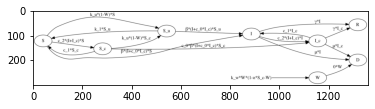

In [62]:
SC2UIR_model.get_transition_graph()

In [39]:
ode = SimulateOde(state, param_list, ode=transition)
ode = ode.get_unrolled_obj()
# R0(ode, ['I','I_c'])   # produces error, no valid subset found

### SC3UEIR model

#### Equations
\begin{equation}
\begin{split}
\dot{S} &= -\beta (I + c_0 I_c) S + c_1 S_c - c_2 S (I + I_c) -  k_u (1 - W) S + k_1 S_u\\
\dot{S_c} &= - c_0 \beta (I + c_0 I_c) S_c - c_1 S_c + c_2 S (I + I_c) -  k_u (1 - W) S_c\\
\dot{E} &= \beta (I + c_0 I_c) (S + S_u) - \alpha E + c_1 E_c - c_2 E (I + I_c)\\
\dot{E_c} &= c_0 \beta (I + c_0 I_c) S_c - \alpha E_c - c_1 E_c + c_2 E (I + I_c)\\
\dot{I} &= \alpha E - \gamma I - \mu I + c_1 I_c - c_2 I (I + I_c)\\
\dot{I_c} &= \alpha E_c - \gamma I_c - \mu I_c - c_1 I_c + c_2 I (I + I_c)\\
\dot{R} & = \gamma (I + I_c) \\
\dot{D} & = \mu (I + I_c) \\
\dot{S_u} & = -\beta (I + c_0 I_c) S_u + k_u (1 - W) (S + S_c)  - k_1 S_u \\
\dot{W} & = k_w W (1 - \kappa S_c - W)
\end{split}
\end{equation}

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $S_u$: Susceptible individuals immune to caution because of economic downturn
* $E$: Exposed individuals
* $E_c$: Exposed individuals exercising caution
* $I$: Infected individuals
* $I_c$: Infected individuals exercising caution
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $W$: Economic status obeying a logistic law with caution individuals downturning
* $N=S+S_c+S_u+E+E_c+I+I_c+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\alpha$ rate at which exposed individuals become infected (1/(incubation time)
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : inverse duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible
* four parameters coupling to economy and uncautionable individuals
    - k_w : rate coefficient of economy equilibration
    - k_u : rate coefficient of transition from uncautioned to uncautionable
    - k_1 : inverse duration of uncautionable state
    - $\kappa$ : economic downturn of caution (proportional to number cautious)

####  Implementation

In [ ]:
# set up the symbolic model

state = ['S', 'E', 'I', 'R', 'D', 'I_c', 'S_c', 'E_c', 'S_u', 'W']
param_list = ['beta', 'alpha', 'gamma', 'mu', 'c_0', 'c_1', 'c_2', 'k_u', 'k_1', 'k_w','kappa', 'N']

transition = [
    Transition(origin='S', equation='-beta*(I+c_0*I_c)*S+c_1*S_c-c_2*(I+I_c)*S-k_u*(1-W)*S+k_1*S_u'),
    Transition(origin='S_c', equation='-c_0*beta*(I+c_0*I_c)*S_c-c_1*S_c+c_2*(I+I_c)*S-k_u*(1-W)*S_c'),
    Transition(origin='S_u', equation='-beta*(I+c_0*I_c)*S_u+k_u*(1-W)*(S+S_c)-k_1*S_u'),
    Transition(origin='E', equation='beta*(I+c_0*I_c)*(S+S_u)-alpha*E+c_1*E_c-c_2*(I+I_c)*E'),
    Transition(origin='E_c', equation='c_0*beta*(I+c_0*I_c)*S_c-alpha*E_c-c_1*E_c+c_2*(I+I_c)*E'),
    Transition(origin='I', equation='alpha*E-gamma*I-mu*I+c_1*I_c-c_2*(I+I_c)*I'),
    Transition(origin='I_c', equation='alpha*E_c-gamma*I_c-mu*I_c-c_1*I_c+c_2*(I+I_c)*I'),
    Transition(origin='R', equation='gamma*(I+I_c)'),
    Transition(origin='D', equation='mu*(I+I_c)'),
    Transition(origin='W', equation='k_w*W*(1-kappa*S_c-W)')
    ]

SC3UEIR_model = DeterministicOde(state, param_list, ode=transition)
SC3UEIR_model.modelname='SC3UEIR'
SC3UEIR_model.ei=slice(1,3) # cases 1,2 i.e. E,I  # note E_c and I_c not included
SC3UEIR_model.confirmed=slice(2,6)  # cases 2-5 i.e. I, R, D, and I_c, not E, E_c
SC3UEIR_model.recovered=slice(3,4)
SC3UEIR_model.deaths=slice(4,5)

In [ ]:
# display equations
print_ode2(SC3UEIR_model)

### SC3UEI3R model

#### Equations 

\begin{equation}
\begin{split}
\dot{S} &={} -(\beta_1 (I_1 + c_0 I_c) + \beta_2 I_2 + \beta_3 I_3) S + c_1 S_c - c_2 S I_3 - S k_u (1-W) + k_1 S_u\\
\dot{S_c} &={} - c_0 (\beta_1 (I_1 + c_0 I_c) + \beta_2 I_2 + \beta_3 I_3) S_c - c_1 S_c + c_2 S I_3 - k_u (1 - W) S_c \\
\dot{E} &= \beta_1 (I_1 + c_0 I_c) (S + S_u) - \alpha E + c_1 E_c - c_2 I_3 E\\
\dot{E_c} &= c_0 \beta_1 (I_1 + c_0 I_c) S_c - \alpha E_c - c_1 E_c + c_2 I_3 E\\
\dot{I_1} &= \alpha E - \gamma_1 I_1 - p_1 I_1 + c_1 I_c - c_2 I_3 I_1\\
\dot{I_c} &= \alpha E_c - \gamma_1 I_c - p_1 I_c - c_1 I_c + c_2 I_3 I_1\\
\dot{I_2} &= p_1 (I_1 + I_c) -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\ 
\dot{R} & = \gamma_1 (I_1 + I_c) +\gamma_2 I_2 + \gamma_3 I_3\\
\dot{D} & = \mu (I_3) \\
\dot{S_u} & = -(\beta_1 (I_1 + c_0 I_c)+\beta_2 I_2 + \beta_3 I_3) S_u + k_u (1 - W)(S+ S_c)  - k_1 S_u \\
\dot{W} & = k_w W (1 - \kappa S_c - W)\\
\end{split}
\end{equation}

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $S_u$: Susceptible individuals immune to caution because of economic downturn
* $W$: Economic status obeying a logistic law with caution individuals downturning
* $E$: Exposed individuals
* $E_c$: Exposed individuals exercising caution
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes. Split non hospital cases by caution.
  * $I_1$: Mild infection (hospitalization not required), living as normal
  * $I_c$: Mild infection (hospitalization not required), exercising caution
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+S_u+E+E_c+I_1+I_c+I_2+I_3+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\alpha$ rate at which exposed individuals become infected (1/(incubation time)
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - $c_0$ : reduction factor for exposure for cautioned susceptibles

    - $c_1$ : inverse duration of caution (exponential decay time constant in days)

    - $c_2$ : rate constant for transition from uncautioned to cautioned susceptible
* four parameters coupling to economy and uncautionable individuals
    - $k_w$ : rate coefficient of economy equilibration
    - $k_u$ : rate coefficient of transition from uncautioned to uncautionable
    - $k_1$ : inverse duration of uncautionable state
    - $\kappa$ : economic downturn of caution (proportional to number cautious)

####  Implementation

In [23]:
# set up the symbolic model

state = ['S', 'E', 'I_1', 'I_2', 'I_3', 'R', 'D',  'I_c', 'S_c', 'E_c', 'S_u', 'W'] # order important to allow correct plot groupings
param_list = ['beta_1', 'beta_2', 'beta_3', 'p_1', 'p_2', 'alpha', 
              'gamma_1', 'gamma_2', 'gamma_3','mu', 'c_0', 'c_1', 'c_2', 'k_u', 'k_1', 'k_w', 'kappa', 'N'] # order also important

transition = [
    Transition(origin='S', equation='-(beta_1*(I_1+c_0*I_c)+beta_2*I_2+beta_3*I_3)*S+c_1*S_c-c_2*(I_3)*S-k_u*(1-W)*S+k_1*S_u'),
    Transition(origin='S_c', equation='-c_0*(beta_1*(I_1+c_0*I_c)+beta_2*I_2+beta_3*I_3)*S_c-c_1*S_c+c_2*(I_3)*S-k_u*(1-W)*S_c'),
    Transition(origin='S_u', equation='-(beta_1*(I_1+c_0*I_c)+beta_2*I_2+beta_3*I_3)*S_u+k_u*(1-W)*(S+S_c)-k_1*S_u'),
    Transition(origin='W', equation='k_w*W*(1-kappa*S_c-W)'),
    Transition(origin='E', equation='beta_1*(I_1+c_0*I_c)*(S+S_u)-alpha*E-c_2*(I_3)*E+c_1*E_c'),
    Transition(origin='E_c', equation='c_0*beta_1*(I_1+c_0*I_c)*S_c-alpha*E_c+c_2*(I_3)*E-c_1*E_c'),
    Transition(origin='I_1', equation='alpha*E-gamma_1*I_1-p_1*I_1-c_2*(I_3)*I_1+c_1*I_c'),
    Transition(origin='I_c', equation='alpha*E_c-gamma_1*I_c-p_1*I_c+c_2*(I_3)*I_1-c_1*I_c'), # changed to I_c, prints better
    Transition(origin='I_2', equation='p_1*(I_1+I_c)-gamma_2*I_2-p_2*I_2'),
    Transition(origin='I_3', equation='p_2*I_2-gamma_3*I_3-mu*I_3'),     # error corrected, this is equation for I_3 not I_2
    Transition(origin='R', equation='gamma_1*(I_1+I_c)+gamma_2*I_2+gamma_3*I_3'),
    Transition(origin='D', equation='mu*I_3')
    ]

SC3UEI3R_model = DeterministicOde(state, param_list, ode=transition)
SC3UEI3R_model.modelname='SC3UEI3R'  # following needs to be adjusted for new models, NB add new species at end to preserve slice subsets
SC3UEI3R_model.ei=slice(1,5)         # 1,2,3,4 i.e. E,I_1,I_2,I_3 – not E_c and I_c 
SC3UEI3R_model.confirmed=slice(2,8)  # cases 2-7 i.e. I1, I2, I3, R, D and I_c
SC3UEI3R_model.recovered=slice(5,6)  # case 5 R
SC3UEI3R_model.deaths=slice(6,7)     # case 6 D

In [ ]:
# display equations
print_ode2(SC3UEI3R_model) # name needs to be that of current model

# Extract data from Johns Hopkins data base

## Definition of data extraction fuctions get_data and get_country_data

In [13]:
import numpy as np
import csv
import itertools
import matplotlib
%matplotlib inline
import seaborn as sb
from matplotlib import pyplot as plt
from cycler import cycler
import datetime
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pwlf
import sys
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [14]:
def get_data(jhu_file):
    dat = []
    with open(jhu_file, newline='') as csvfile:
        myreader = csv.reader(csvfile, delimiter=',')
        popdat = []
        i = 0
        for row in myreader:
            if i != 0:
                poplist = []
                j = 0
                for elt in row:
                    if j >= 4:
                        poplist.append(int(elt))
                    elif j == 0:
                        poplist.append(elt)
                    elif j == 1:
                        poplist[0]=(elt,poplist[0])
                    j = j+1
                popdat.append(poplist)
            else:
                popdat.append(row)
            # print(popdat[i])
            i = i + 1;
    # dates
    popdat0=['dates']
    for elt in popdat[0][4:]:
        popdat0.append(elt)
    popdat[0] = [pop for pop in popdat0]
    # print('popdat[0]',popdat[0])
    # totals over all countries
    totals = np.zeros(len(popdat[0])-1,dtype=int)
    for row in popdat[1:]:
        totals = totals + np.array(row[1:])
    totals = list(np.asarray(totals))
    # print(totals)
    popkeyed = {poplist[0]: poplist[1:] for poplist in popdat}
    popkeyed.update({'dates':popdat[0][1:]})
    popkeyed.update({('World',''):totals})
    # del popkeyed[('d','a')]
    # assemble totals for countries with multiple regions
    total = np.zeros(len(popkeyed['dates']),dtype=int)
    poptotkeyed = {}
    for country,tseries in popkeyed.items():
        if country!='dates' and country[1] != '': # it seems that UK is single exception with both '' and non '' regions, UK total is then UK overseas
            countrytotal = (country[0],'Total')
            if countrytotal in poptotkeyed:
                # print(country,popkeyed[country],poptotkeyed[countrytotal])
                total = np.array(tseries)[:]+np.array(poptotkeyed[countrytotal])[:]
            else:
                total =  np.array(tseries)                        
            poptotkeyed.update({countrytotal:list(total)})
    for countrytotal,tseries in poptotkeyed.items():
        total = np.array(tseries)
        popkeyed.update({countrytotal:list(total)})
    return popkeyed

In [15]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn

In [16]:
# from covid_data_explore-jhu-j
def get_country_data(country_s='World', datatype='confirmed', firstdate=None, lastdate=None):
    if isinstance(country_s,str):
        country = (country_s,'')
    else:                               # single ('country','reg') entry
        country = country_s
    popkeyed = covid_ts[datatype]
    
    dates = popkeyed['dates']
    fmt = '%m/%d/%y'
    xx = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    if firstdate:
        firstdate_d = datetime.datetime.strptime(firstdate,fmt)
    else:
        firstdate_d = datetime.datetime.strptime(dates[0],fmt)
    if lastdate:
        lastdate_d = datetime.datetime.strptime(lastdate,fmt)
    else:
        lastdate_d = datetime.datetime.strptime(dates[-1],fmt)    
    daystart = (firstdate_d-xx[0]).days
    daystop = (lastdate_d-xx[-1]).days

    try:
        yy = popkeyed[country]
        # print(country)
    except:
            print('country data not found',country)
            return None,None,None
    yyf = [Float(y) for y in yy]
    
    if daystart <0:
        xx0 = [xx[0]+datetime.timedelta(days=i) for i in range(daystart,0)]
        yy0 = [0.]*(-daystart)
    else:
        xx0 = []
        yy0 = []
    if daystop > 0:
        xx1 = [xx[-1]+datetime.timedelta(days=i) for i in range(daystop)]
        yy1 = [0.]*(daystop)
    else:
        xx1 = []
        yy1 = []       
    xx = xx0 + xx + xx1
    xxf = [Float((x-firstdate_d).days) for x in xx ]
    
    yy = yy0 + yyf + yy1
    return xx,xxf,yy 



In [17]:
def get_country_data_nyw(country_s='World', datatype='confirmed', firstdate=None, lastdate=None):
    if isinstance(country_s,str):
        country = (country_s,'')
    else:                               # single ('country','reg') entry
        country = country_s
    popkeyed = covid_ts[datatype]
    
    dates = popkeyed['dates']
    fmt = '%m/%d/%y'
    xx = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    if firstdate:
        firstdate_d = datetime.datetime.strptime(firstdate,fmt)
    else:
        firstdate_d = datetime.datetime.strptime(dates[0],fmt)
    if lastdate:
        lastdate_d = datetime.datetime.strptime(lastdate,fmt)
    else:
        lastdate_d = datetime.datetime.strptime(dates[-1],fmt)    
    daystart = (firstdate_d-xx[0]).days
    daystop = (lastdate_d-xx[-1]).days
    
    try:
        yy = popkeyed[country]
        # print(country)
    except:
            print('country data not found',country)
            return None,None      
    yyf = [Float(y) for y in yy]

    yy0 = []
    yy1 = []  
    if daystart>len(yyf):
        print('Error: start date does not overlap with available data')
        return None,None
    elif daystart>0:
        yyf = yyf[daystart:]
    elif daystart <0:
        yy0 = [0.]*(-daystart)
        
    if daystop < 0:
        yyf = yyf[:daystop]  
    elif daystop > 0:
        yy1 = [0.]*(daystop)
    yyf = yy0 + yyf + yy1
    xxf = [float(x) for x in range(len(yyf))]
    return xxf,yyf 

## JHU data

In [18]:
base = '../../covid-19-JH/csse_covid_19_data/csse_covid_19_time_series/'
confirmed = get_data(base+'time_series_covid19_confirmed_global.csv')
deaths = get_data(base+'time_series_covid19_deaths_global.csv')
recovered = get_data(base+'time_series_covid19_recovered_global.csv')
covid_ts = {'confirmed':confirmed,'deaths':deaths,'recovered':recovered}
countries_jhu = [(row[0],row[1]) for row in confirmed][1:]
print("number of countries listed",len(countries_jhu))
i=0
for country in countries_jhu:
#    print(i,country)
    i = i + 1

number of countries listed 274


## Get data for one country

In [19]:
# assumed data starting on firstdate
test_country='Germany'
N = 80000000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0,

## OWID data

In [20]:
import csv
owid_file = '../../covid-19-owid/public/data/owid-covid-data.csv'
covid_owid = []
with open(owid_file,'r',newline='') as fp:
    myreader = csv.DictReader(fp,delimiter=',')
#    rows = list(itertools.islice(myreader,4))
    for row in myreader:
        covid_owid.append(row)
covid_owid[0].keys()

odict_keys(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy'])

In [21]:
def get_data_owid(owid_file,database='owid',datatype='confirmed',dataaccum = 'cumulative'):
    import numpy as np
    import datetime
    import matplotlib.dates as mdates
    
    global covid_owid
    if not covid_owid:
        with open(owid_file, 'r', newline='') as csvfile:
            myreader = csv.DictReader(csvfile,delimiter=',')
            for row in myreader:
                covid_owid.append(row)
        close(owid_file)
        
    # for key in covid_owid[0].keys():   # to loop through all keys
    
    if datatype == 'confirmed':
        if dataaccum == 'cumulative':
            key = 'total_cases'
        elif dataaccum == 'weekly':
            key = 'new_cases_smoothed'
        else:
            key = 'new_cases'
    elif datatype == 'recovered':
        print('data for recovered cases not available in OWID database')
        key = None
    elif datatype == 'deaths':
        if dataaccum == 'cumulative':
            key = 'total_deaths'
        elif dataaccum == 'weekly':
            key = 'new_deaths_smoothed'
        else:
            key = 'new_deaths'
    elif datatype == 'tests':
        if dataaccum == 'cumulative':  # reporting intervals often sporadic so better to use smoothed weekly
            # key = 'total_tests'
            key = 'new_tests_smoothed'  # will adjust to cumulative below
        elif dataaccum == 'weekly':
            key = 'new_tests_smoothed'
        else:
            key = 'new_tests'          # reporting intervals often sporadic so better to use smoothed weekly
    elif datatype =='stringency':
        key = 'stringency_index'
    elif datatype == 'recovered':
        print('data for recovered cases not available in OWID database')
        key = None
        return 
    else:
        print('data for ', datatype,'not available or not yet translated in OWID database')
        key = None
        return
   
    countries = np.unique(np.array([dd['location'] for dd in covid_owid]))
    dates = np.unique(np.array([dd['date'] for dd in covid_owid]))
    dates.sort()
    fmt = '%Y-%m-%d'
    dates_t = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    firstdate = dates[0]
    lastdate = dates[-1]
    firstdate_t =  dates_t[0]
    lastdate_t =  dates_t[-1]

    daystart = 0
    daystop = (lastdate_t-firstdate_t).days
    
    popkeyed = {country: np.zeros(daystop+1,dtype=float) for country in countries} 
    
    for dd in covid_owid:
        country = dd['location']
        day = (datetime.datetime.strptime(dd['date'],fmt)-firstdate_t).days
        popkeyed[country][day] = float(dd[key]) if not dd[key]=='' else 0.0 
        
    # popkeyed = {country: np.transpose(np.array([[dd['date'],dd[key]] for dd in covid_owid if dd['location'] == country])) for country in countries}
    # popkeyed = {country: np.array([float(dd[key]) if not dd[key]=='' else 0.0 for dd in covid_owid if dd['location'] == country]) for country in countries} 

    if datatype == 'tests' and dataaccum == 'cumulative':  # assemble cumulative tests from smooth daily tests
        for country in countries:
            data = popkeyed[country]
            sumdata= np.zeros(len(data))
            sum = 0.0
            for i,d in enumerate(data):
                sum = sum + d
                sumdata[i] = sum
            popkeyed.update({country:sumdata})

    fmt_jhu = '%m/%d/%y'
    popkeyed.update({'dates': [date.strftime(fmt_jhu) for date in dates_t]})   # dates are set to strings in jhu date format for compatibility
    return popkeyed

In [22]:
owid_file = '../../covid-19-owid/public/data/owid-covid-data.csv'
confirmed_owid=get_data_owid(owid_file,database='owid',datatype='confirmed',dataaccum = 'cumulative')
recovered_owid = None
deaths_owid=get_data_owid(owid_file,database='owid',datatype='deaths',dataaccum = 'cumulative')
tests_owid=get_data_owid(owid_file,database='owid',datatype='tests',dataaccum = 'cumulative')
stringency_owid=get_data_owid(owid_file,database='owid',datatype='stringency',dataaccum = 'daily')
covid_owid_ts= {'confirmed':confirmed_owid,'deaths':deaths_owid,'recovered':recovered_owid, 'tests': tests_owid , 'stringency': stringency_owid}

In [41]:
def truncx(xx,daystart,daystop):
    """truncate array xx to run from daystart to daystop
       do this before trying to extend the arrays if required"""
    daymin = max(daystart,0)
    daymax = min(daystop,(xx[-1]-xx[0]).days)
    return xx[daymin:daymax+1]

def truncy(xx,yy,daystart,daystop):
    """truncate arrays xx and yy to run from daystart to daystop
       do this before trying to extend the arrays if required"""
    daymin = max(daystart,0)
    daymax = min(daystop,(xx[-1]-xx[0]).days)
    return yy[daymin:daymax+1]

def plotCountry_(country_s, datatype='confirmed', dataaccum='cumulative', fittype=None, ax=None, ax2=False,
                symbol='o--', step=None, firstdate=None, lastdate=None, intdates=False, linecolor=None, maxyval=None, minconfirmed=0,nsegments=3,database='jhu'):
    """ plots selected data for a list of countries or single country
        datatypes allowed are 'confirmed','deaths','recovered'
        dataaccum specifies either 'cumulative' or 'daily' or averaged over 7 days 'cum_av_weekly' or 'daily_av_weekly'
        fittypes allowed are currently None, 'piecewise-linear'
        ax graphical axes to use for plot: default None -> new axes
        ax2 true if second axes as twin axes for overlay plotting
        symbol to use for plotting
        step whether to use step plotting instead of points: default None -> points
        firstdate to plot (maybe before first date in data - pad with 0)
        lastdate to plot (maybe after last date in data - pad with 0)
        intdates : whether to plot dates as integers for compatibility (default as dates)
        linecolor is default color to use for a single trace, instead of listed set)
    """
    global covid_ts, covid_ts_owid
    import math
    import warnings
    # extract list of countries in [(country,region),...] format from first parameter
    countries = []
    if isinstance(country_s,list):
        for country in country_s:
            if isinstance(country,str) and database == 'jhu':
                country = (country,'')
            countries.append(country)
    elif isinstance(country_s,str):
        if database == 'jhu':
            countries = [( country_s,'')]
        else:
             countries = [country_s]
    else:                               # single ('country','reg') entry
        countries = [country_s]
        
    # get data with datatype and extend dates to padd desired interval specified by firstdate,lastdate
    if database == 'jhu':
        popkeyed = covid_ts[datatype]
        dates = popkeyed['dates']
        fmt = '%m/%d/%y'
    elif database == 'owid':
        popkeyed = covid_owid_ts[datatype]
        dates = popkeyed['dates']
        fmt = '%m/%d/%y'
        # fmt = '%Y-%m-%d' the owid date format was converted to the jhu date format in get_data_owid
    xxd = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    if firstdate:
        firstdate_d = datetime.datetime.strptime(firstdate,fmt)
    else:
        firstdate_d = datetime.datetime.strptime(dates[0],fmt)
    if lastdate:
        lastdate_d = datetime.datetime.strptime(lastdate,fmt)
    else:
        lastdate_d = datetime.datetime.strptime(dates[-1],fmt)
    daystart = (firstdate_d-xxd[0]).days
    daystop = (lastdate_d-xxd[0]).days
    xx = [0.]*(daystop-daystart+1)
    xx = truncx(xxd,daystart,daystop)
    # print('1 len xx',len(xx))
    
    if daystart <0:
        xx0 = [xx[0]+datetime.timedelta(days=i) for i in range(daystart,0)]
        yy0 = [0.]*(-daystart)
    else:
        xx0 = []
        yy0 = []

    if daystop > (xxd[-1]-xxd[0]).days:
        xx1 = [xxd[-1]+datetime.timedelta(days=i) for i in range(daystop-(xxd[-1]-xxd[0]).days)]
        yy1 = [' ']*(daystop-(xxd[-1]-xxd[0]).days)
    else:
        xx1 = []
        yy1 = []       
    xx = xx0 + xx + xx1
    # print('2 len xx',len(xx))
    #print('len xx1 yy1',len(xx1),len(yy1))
    
    # print('len xx',len(xx))
    if fittype == 'piecewise-linear':
        xxi = [Float((x-xx[0]).days) for x in xx ]
        # print(xxi)
    # print('len xxi',len(xxi))    
    # locator = mdates.MonthLocator()
    locator = mdates.AutoDateLocator(minticks=5, maxticks=13)
    formatter= mdates.ConciseDateFormatter(locator)
    
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(9,6)) 
        ax2 = ax
    elif ax2:
        ax2 = ax.twinx()
    else:
        ax2 = ax
        
    colors =  ['k', 'b', 'c', 'm', 'y', 'g', 'olive', 'chocolate']
        
    i = 0
    j = 0
    for country in countries:
        try:
            yyd = popkeyed[country]
            if np.max(yyd) >= minconfirmed:
                j = j+1
            else:
                i = i + 1
                continue
        except:
            print('country not found',country)
            i = i + 1
            continue
        yy = truncy(xxd,yyd,daystart,daystop)
        # print(country,'1 len yy yyd',len(yy),len(yyd))
        yyf = [Float(y) for y in yy]
        yy = yy0 + yyf + yy1
        # print(country,'2 len yy',len(yy))
        # ymax=np.max(np.array(yy))
        yyf = [Float(y) for y in yy]
        if dataaccum == 'daily':
            yy = [0.]*len(yy)
            yy[0] = yyf[0]
            for k in range(1,len(yy)):
                yy[k] = yyf[k]-yyf[k-1]   
        elif dataaccum == 'cum_av_weekly':
            yy = [0.]*len(yy)
            moving_av = 0.
            for k in range(len(yy)):
                if k-7 >= 0:
                    moving_av = moving_av - yyf[k-7]
                moving_av = moving_av + yyf[k]
                yy[k] = moving_av/min(7.0,float(k+1))
        elif dataaccum == 'daily_av_weekly':
            yy = [0.]*len(yyf)
            yy[0] = yyf[0]
            for k in range(1,len(yy)):
                yy[k] = yyf[k]-yyf[k-1]
            yyf = [y for y in yy]
            yy = [0.]*len(yy)
            moving_av = 0.
            for k in range(len(yy)):
                if k-7 >= 0:
                    moving_av = moving_av - yyf[k-7]
                moving_av = moving_av + yyf[k]
                yy[k] = moving_av/min(7.0,float(k+1))
        if intdates:
            xx = range(len(xx))
        
        if step:
            ax2.step(xx,yy,label = country[0])
        else:
            # print(ax,ax2)
            # ax2.set_ylim(ymax,0)
            if linecolor:
                color = linecolor
            else:
                color = colors[i]

            ax2.plot(xx, yy, symbol, markersize=3, color = color, alpha=0.8, label = country[0])

        if maxyval: ax.set_ylim(0,maxyval)
        if maxyval: ax2.set_ylim(0,maxyval)
            
        plt.title(country[0]+'-'+country[1])  # +' '+datatype)
        if fittype == 'piecewise-linear':    
            warnings.filterwarnings("ignore", message="Warning: zero length interval encountered in pwlf.py calc_slopes")
            # initialize piecewise linear fit with your x and y data
            # yyf = [Float(y) for y in yy]
            yyf = [Float(y) if not math.isnan(y) else 0.0 for y in yy]
            # print(yyf)
            my_pwlf = pwlf.PiecewiseLinFit(xxi, yyf)
            # fit the data for three line segments
            res = my_pwlf.fit(nsegments)
            
            ppp = my_pwlf.p_values(method='non-linear', step_size=1e-4)
            se = my_pwlf.se  # standard errors
            parameters = np.concatenate((my_pwlf.beta,
                             my_pwlf.fit_breaks[1:-1]))
            header = ['Parameter type', 'Parameter value', 'Standard error', 't         ', 'P > np.abs(t) (p-value)']
            print(*header, sep=' | ')
            values = np.zeros((parameters.size, 5), dtype=np.object_)
            values[:, 1] = np.around(parameters, decimals=3)
            values[:, 2] = np.around(se, decimals=3)
            values[:, 3] = np.around(parameters / se, decimals=3)
            values[:, 4] = np.around(ppp, decimals=3)
            for iii, row in enumerate(values):
                if iii < my_pwlf.beta.size:
                    row[0] = 'Slope     '
                    print(*row, sep='     | ')
                else:
                    row[0] = 'Breakpoint'
                    print(*row, sep='     | ')
            print("")      
            # predict for the determined points
            xHat = np.linspace(min(xxi), max(xxi), num=len(xx))
            # print(len(xHat),len(xxi))
            yHat = my_pwlf.predict(xHat)
            ax2.plot(xx, yHat, color = colors[i], alpha=0.5, label = country[0]+' fit')
            
        i = i+1

    if j==0:
        ax.axis("off")
    else:
        if j > 1:
            plt.legend(loc="upper left")
            plt.title('countries '+datatype+dataaccum)
        if not intdates:
            ax2.xaxis.set_major_formatter(formatter)
            ax2.xaxis.set_major_locator(locator)
            for tick in ax2.get_xticklabels():
                tick.set_rotation(40)



## Plots of data for Cautionary Model comparison

Comment out line 1110 in pwlf.py (in /⁨usr⁩/local⁩/lib⁩/⁨python3.7⁩/site-packages⁩/pwlf⁩ directory)
    print("Warning: zero length interval encountered in pwlf.py calc_slopes").  
to remove repeated warnings, which don't seem to harm final result
    Warning: zero length interval encountered in pwlf.py calc_slopes

Parameter type | Parameter value | Standard error | t          | P > np.abs(t) (p-value)
Slope          | -2153.968     | 861.47     | -2.5     | 0.013
Slope          | 314.292     | 54.759     | 5.74     | 0.0
Slope          | 4402.357     | 68.356     | 64.403     | 0.0
Slope          | -2493.497     | 73.62     | -33.87     | 0.0
Slope          | -1912.27     | 61.584     | -31.051     | 0.0
Breakpoint     | 27.629     | 0.272     | 101.649     | 0.0
Breakpoint     | 61.522     | 0.489     | 125.767     | 0.0
Breakpoint     | 87.508     | 0.533     | 164.077     | 0.0

Parameter type | Parameter value | Standard error | t          | P > np.abs(t) (p-value)
Slope          | -1723.371     | 1656.21     | -1.041     | 0.299
Slope          | 181.842     | 86.277     | 2.108     | 0.036
Slope          | 5878.275     | 122.015     | 48.177     | 0.0
Slope          | -5448.02     | 87.859     | -62.008     | 0.0
Slope          | 4665.851     | 105.423     | 44.258     | 0.0
Breakpoint     

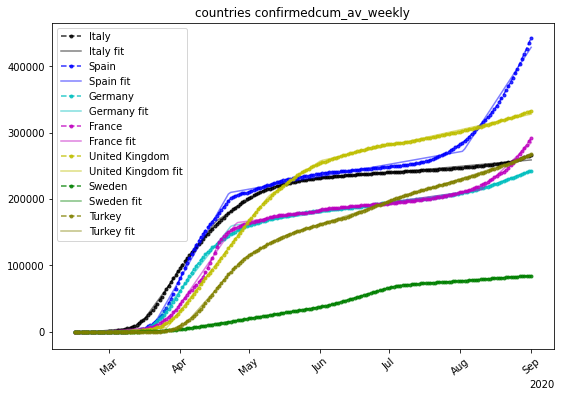

In [42]:
plotCountry_(['Italy','Spain','Germany','France','United Kingdom','Sweden','Turkey'],
             'confirmed','cum_av_weekly',firstdate='02/15/20',lastdate='09/1/20',fittype='piecewise-linear',nsegments=4)
#plt.savefig("covid-19-caution/figures/fig1a.pdf",bbox_inches='tight')

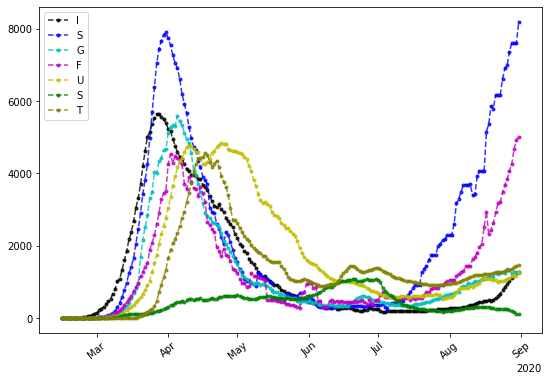

In [32]:
plotCountry_(['Italy','Spain','Germany','France','United Kingdom','Sweden','Turkey'],
            'confirmed','daily_av_weekly',firstdate='02/15/20',lastdate='08/31/20',database='owid')
plt.title("");
# plt.plot(xx,[450000*d[1] for d in dat],linewidth=6,color='salmon',alpha=0.5,linestyle='--');
# plt.savefig("covid-19-caution/figures/fig1b.pdf",bbox_inches='tight')

# Simulation

Note:  Problem with setting parameters in model.

The DeterministicOde Class method parameters, converts a dictionary or list of tuples of parameters to a dictionary with sympy symbolic keys, not strings.
So attempts to modify parameter values by accessing this dictionary fail. Copying the dictionary, modifying and rewriting also fail.
Instead we store the dictionary of parameters in addition as a dictionary with string keys, under model.params. When we modify these values, they can then be copied back to the parameters method using model.parameters = model.params.

## Simulation of SCIR model

In [ ]:
# setup time points for simulation, initial conditions and parameters
t = np.linspace(0, lastday -1, lastday)

# initial conditions assuming there is no natural immunity
I_0 =  0.00003
x0_SCIR = [1.0-I_0, I_0, 0.0, 0.0, 0.0]

# Define parameters based on clinical observations Dr. Alison
Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurInf=10 #Duration of mild infections, days
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.05 #Case fatality rate (fraction of infections resulting in death)
TimeDeath=DurInf+7 #Time from ICU admission to death, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.4 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.25 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.002 # Fraction of ICUs relative to population size N

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.125  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# convert above parameters to model parameters
params = {'beta' : Exposure/sum(x0_SCIR),
          'gamma': (1.0/DurInf),
          'mu'    : (1.0/TimeDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SCIR)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SCIR)}
print(params)
# assign x0 and params to the model, integrate over t and plot
SCIR_model.initial_values = (x0_SCIR, t[0])
SCIR_model.parameters = params
SCIR_model.params = params.copy()
solution = SCIR_model.integrate(t[1::])

SCIR_model.plot()

# calculate time point when maximum number of people are infectious
peak_i = np.argmax(solution[:,1])
print('Peak infection (days)', t[peak_i])

### Integration and plot using scipy and matplotlib directly

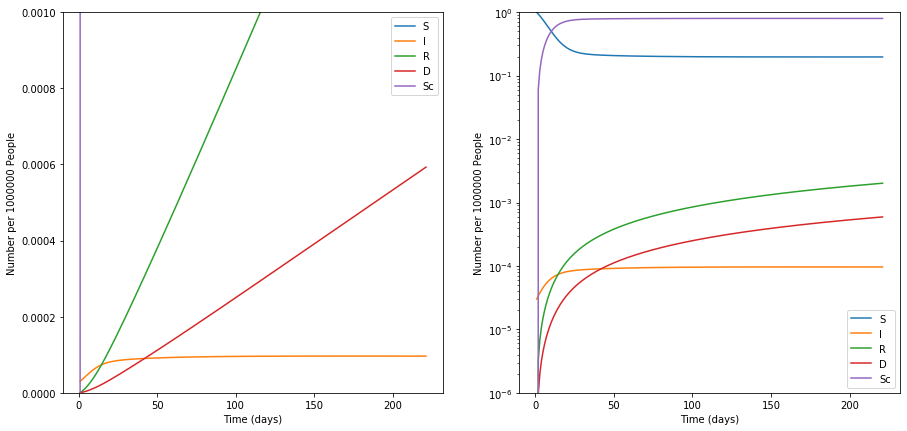

In [32]:
solution1 = scipy.integrate.odeint(SCIR_model.ode, x0_SCIR, t[1::])
ys = solution1.copy()
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.ylim([0,0.001])
plt.plot(t[1::],ys,label=("S","I","R","D","Sc"))
plt.legend(("S","I","R","D","Sc"))
plt.subplot(1,2,2)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.ylim([0.000001,1])
plt.semilogy()
plt.plot(t[1::],ys,label=("S","I","R","D","Sc"))
plt.legend(("S","I","R","D","Sc"));

### Test dumpparams() and loadparams()

In [33]:
SCIR_model.params

{'beta': 0.25,
 'gamma': 0.1,
 'mu': 0.029411764705882353,
 'c_0': 0.4,
 'c_1': 0.047619047619047616,
 'c_2': 2000.0,
 'N': 1.0}

In [34]:
SCIR_model.params['beta']

0.25

In [35]:
SCIR_model.dumpparams()

dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SCIR.pk


In [36]:
params1 = SCIR_model.params.copy()

In [37]:
params1

{'beta': 0.25,
 'gamma': 0.1,
 'mu': 0.029411764705882353,
 'c_0': 0.4,
 'c_1': 0.047619047619047616,
 'c_2': 2000.0,
 'N': 1.0}

In [22]:
pk.dump(params1,open('foo','wb')) # this works!?!?


In [38]:
SCIR_model.loadparams()

loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SCIR.pk :


True

In [39]:
params1 = SCIR_model.params.copy()
params1

{'beta': 0.25,
 'gamma': 0.1,
 'mu': 0.029411764705882353,
 'c_0': 0.4,
 'c_1': 0.047619047619047616,
 'c_2': 2000.0,
 'N': 1.0}

In [40]:
'beta' in params1

True

Good: but still need to set .parameters before values can be used by simulation

In [ ]:
SCIR_model.parameters = params1

### Compare data with SCIR simulation

In [58]:
# model with generating parameters 
params1 = SCIR_model.params.copy()
params1['c_0']=0.85
params1['beta']=0.15
SCIR_model.parameters = params1
print('parameters',SCIR_model.parameters)
x0_fit = x0_SCIR.copy()
print('initial conditions',x0_fit)
t_fit = t
SCIR_model.initial_values = (x0_fit, t_fit[0])
sol_fit = scipy.integrate.odeint(SCIR_model.ode, x0_fit, t_fit[1::])
plt.figure(figsize=(15,10))
plt.plot(t,y_jhu[test_country][:,1]/FracRecoveredDet, 'bo',label='R') # recovered
plt.plot(t,y_jhu[test_country][:,2], 'ro',label='D') # died
plt.gca().set_prop_cycle(color=['grey','orange','green','green','green','blue','red', 'black'])
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.02])
plt.legend()
peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

Exception: Too many input parameters

### Stochastic simulation

In [109]:
N=10000
I_0 =  10
x0_SCIR_S = [N-I_0, I_0, 0, 0, 0]
# Define parameters based on clinical observations Dr. Alison
Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurInf=10 #Duration of mild infections, days
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.05 #Case fatality rate (fraction of infections resulting in death)
TimeDeath=DurInf+7 #Time from ICU admission to death, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.4 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.25 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.02 # Fraction of ICUs relative to population size N                                                       # increased 10X for low pop simulation

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.125  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0
params_S = {'beta' : Exposure/sum(x0_SCIR_S),
          'gamma': (1.0/DurInf),
          'mu'    : (1.0/TimeDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SCIR_S)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SCIR_S)}
SCIR_modelS.initial_values = (x0_SCIR_S, t[0])
SCIR_modelS.parameters = params_S
SCIR_modelS.params = params_S.copy()
t_jump = np.linspace(0,100,50)
simX, simT =SCIR_modelS.simulate_jump(t_jump, iteration=5, full_output=True)

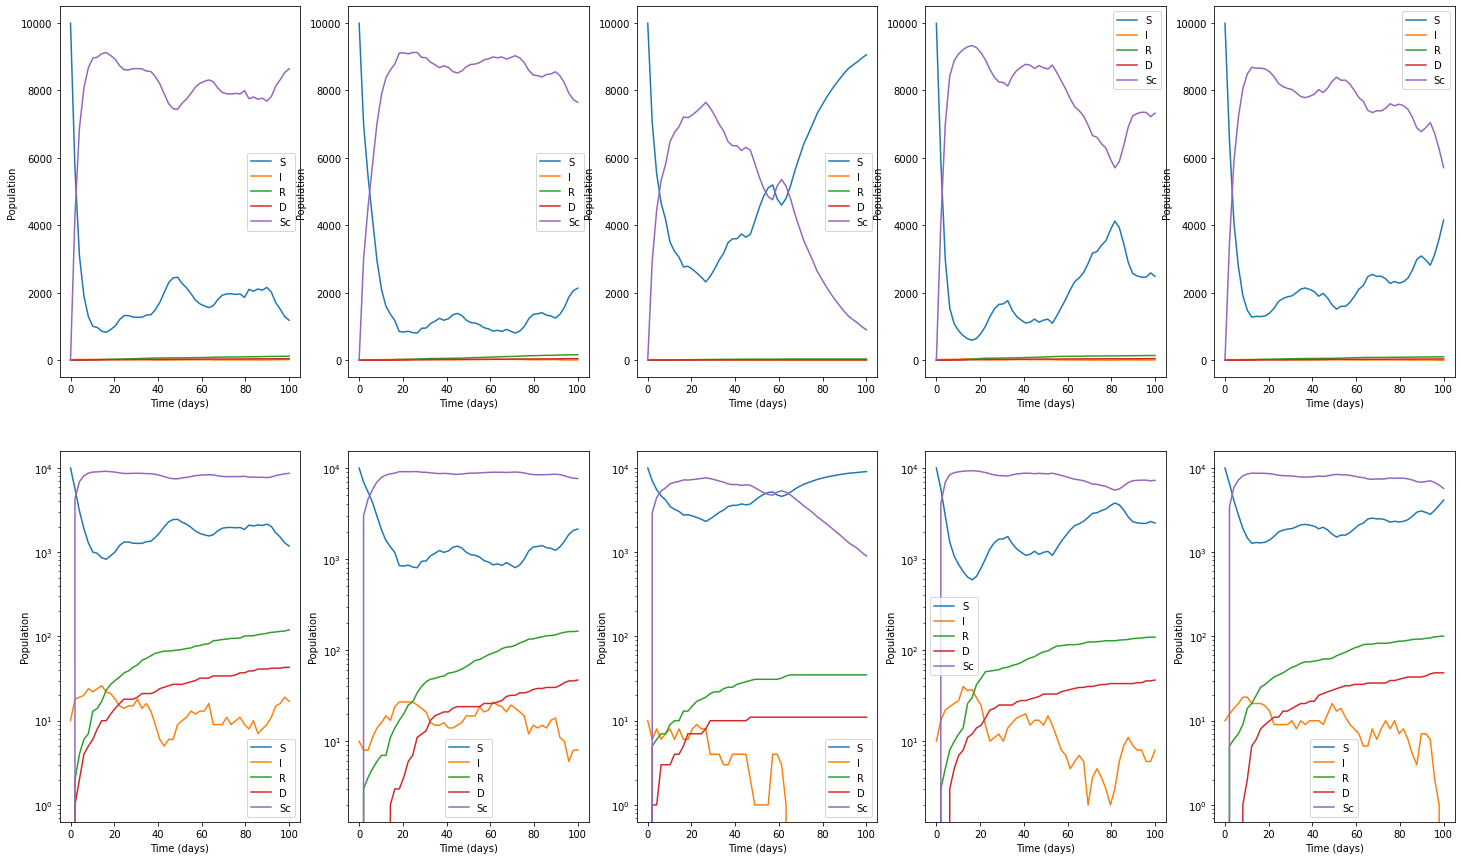

In [110]:
plt.figure(figsize=(25,15))

for iter in range(5):
    plt.subplot(2,5,iter+1)
    plt.xlabel("Time (days)")
    plt.ylabel("Population")
    plt.plot(simT,simX[iter],label=("S","I","R","D","Sc"))
    plt.legend(("S","I","R","D","Sc"))
for iter in range(5):
    plt.subplot(2,5,5+iter+1)
    plt.xlabel("Time (days)")
    plt.ylabel("Population")
    plt.semilogy()
    plt.plot(simT,simX[iter],label=("S","I","R","D","Sc"))
    plt.legend(("S","I","R","D","Sc"));

## Simulation of SC2IR model

parameters {'beta': 0.25, 'gamma': 0.1, 'mu': 0.029411764705882353, 'c_0': 0.4, 'c_1': 0.047619047619047616, 'c_2': 2000.0, 'N': 1.0}


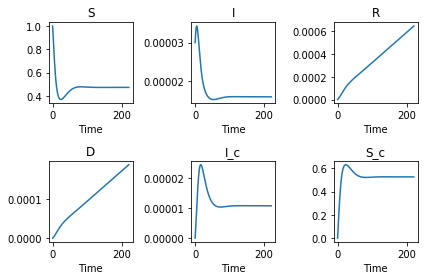

Peak infection (days) 5.0


In [26]:
# setup time points for simulation, initial conditions and parameters
t = np.linspace(0, lastday -1, lastday)

# initial conditions assuming there is no natural immunity
I_0 =  0.00003
x0 = [1.0-I_0, I_0, 0.0, 0.0, 0.0, 0.0]

# Define parameters based on clinical observations Dr. Alison
Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurInf=10 #Duration of mild infections, days
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.05 #Case fatality rate (fraction of infections resulting in death)
TimeDeath=DurInf+7 #Time from ICU admission to death, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.4 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.25 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.002 # Fraction of ICUs relative to population size N

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.125  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# convert above parameters to model parameters
params = {'beta' : Exposure/sum(x0),
          'gamma': (1.0/DurInf),
          'mu'    : (1.0/TimeDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0)}
print('parameters',params)
# assign x0 and params to the model, integrate over t and plot
SC2IR_model.initial_values = (x0, t[0])
SC2IR_model.parameters = params
SC2IR_model.params = params.copy()
solution = SC2IR_model.integrate(t[1::])

SC2IR_model.plot()

# calculate time point when maximum number of people are infectious
peak_i = np.argmax(solution[:,1])
print('Peak infection (days)', t[peak_i])

### Integration and plot using scipy and matplotlib directly

In [ ]:
solution1 = scipy.integrate.odeint(SC2IR_model.ode, x0, t[1::])
ys = solution1.copy()
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.xlabel("Time (days)")
plt.ylabel("Fraction of population")
plt.ylim([0,1])
plt.gca().set_prop_cycle(color=['grey','green','blue','red','darkgreen', 'black'])
plt.plot(t[1::],ys,label=("S","I","R","D",'Ic',"Sc"))
plt.legend(("S","I","R","D","Ic","Sc"))
plt.title(SC2IR_model.modelname)
plt.subplot(1,2,2)
plt.xlabel("Time (days)")
plt.ylabel("Fraction of population")
plt.ylim([0.000001,1])
plt.semilogy()
plt.gca().set_prop_cycle(color=['grey','green','blue','red','darkgreen', 'black'])
plt.plot(t[1::],ys,label=("S","I","R","D",'Ic',"Sc"))
plt.legend(("S","I","R","D","Ic","Sc"))
plt.title(SC2IR_model.modelname + ' - semilog');

### Compare data with SC2IR simulation

In [ ]:
# model with generating parameters 
def isolveplot(beta,gamma,mu,c_0,c_1,c_2,logI_0):
    # saveparams=SC2IR_model.parameters.copy() # backup model current parameters
    # saveICs = SC2IR_model.initial_values # back model ICs
    I_0 = 10.**logI_0
    x0 = [1.0-I_0, I_0, 0.0, 0.0, 0.0, 0.0]
    params = {'beta' : beta,
          'gamma': gamma,
          'mu'    : mu,
          'c_0'    : c_0,
          'c_1'    : c_1,
          'c_2'    : c_2,
          'N'     : sum(x0)}
    SC2IR_model.initial_values = (x0, t[0])
    SC2IR_model.parameters = params.copy()
    
    sol_fit = scipy.integrate.odeint(SC2IR_model.ode, x0, t[1::])
    #
    plt.figure(figsize=(15,10))
    plt.plot(t,y_jhu[test_country][:,1]/FracRecoveredDet, 'bo',label='R') # recovered
    plt.semilogy()
    plt.plot(t,y_jhu[test_country][:,2], 'ro',label='D') # died
    plt.semilogy()
    plt.gca().set_prop_cycle(color=['grey','green','blue','red','darkgreen','black'])
    plt.plot(t[1::], sol_fit)
    plt.ylim([0.000001,1])
    plt.semilogy()
    plt.legend(('R','D','S','I','R','D','I_c','S_c'))
    #plt.show(())
    #ode_fit.plot()

    peak_i = np.argmax(sol_fit[:,2])
    print('Peak infection (days)', t_fit[peak_i])
    # SC2IR_model.parameters=saveparams.copy()
    # SC2IR_model.initial_values=saveICs

In [ ]:
params = {'beta' : 0.25,
          'gamma': 0.1,
          'mu'    : 0.05,
          'c_0'    : 0.3,
          'c_1'    : 1./14.,
          'c_2'    : 2000.,
          'N'     : 1.}
interact(isolveplot,
         beta=FloatSlider(min=0,max=1,step=0.01,value=params['beta'],description='beta',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         gamma=FloatSlider(min=0,max=1,step=0.01,value=params['gamma'],description='gamma',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.1,step=0.001,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=np.log10(x0[1]),description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False))

In [ ]:
slide_params=SC2IR_model.parameters.copy()
print(slide_params)
theta = [0.4,0.11,0.007,0.33,0.228,275.]

## Simulation of SCEI3R model

In [ ]:
# setup time points for simulation, initial conditions and parameters
t = np.linspace(0, lastday -1, lastday)

# initial conditions assuming there is no natural immunity
E_0 =  0.00003
x0_SCEI3R = [1.0-E_0, E_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Define parameters based on clinical observations Dr. Alison
Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days
FracMild=0.70  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.07 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=7 #Time from ICU admission to death, days
DurHosp=11 #Duration of hospitalization, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.2 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.3 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.002 # Fraction of ICUs relative to population size N

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.125  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# convert above parameters to model parameters
params = {'beta_1' : Exposure/sum(x0_SCEI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SCEI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SCEI3R)}
print(params)
# assign x0 and params to the model, integrate over t and plot
SCEI3R_model.initial_values = (x0_SCEI3R, t[0])
SCEI3R_model.parameters = params
SCEI3R_model.params = params.copy()
solution = SCEI3R_model.integrate(t[1::])

SCEI3R_model.plot()

# calculate time point when maximum number of people are infectious
peak_i = np.argmax(solution[:,2])
print('Peak infection (days)', t[peak_i])

### Compare data with SCEI3R simulation

In [ ]:
# model with generating parameters 
params1 = SCEI3R_model.params.copy()
params1['c_0']=0.7
SCEI3R_model.parameters = params1
print(SCEI3R_model.parameters)
x0_fit = x0_SCEI3R.copy()
# x0_fit[2] = 0.00001
#t_fit = numpy.linspace(0, 150, 1000)
print(x0_fit)
t_fit = t
print(len(t))
SCEI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
#sol_fit =SCEI3R_model.integrate(t_fit[1::])
# sol_fit = SCEI3R_model.integrate(t_fit)
sol_fit = scipy.integrate.odeint(SCEI3R_model.ode, x0_fit, t_fit[1::])
# print(len(sol_fit[0]))
#
plt.figure(figsize=(15,10))
#plt.plot(t,y_jhu[test_country][:,0], 'go',label='I_1') # infected observations
#plt.plot(t,y_jhu[test_country][:,1], 'go',label='I_2') # infected observations
#plt.plot(t,y_jhu[test_country][:,2], 'go',label='I_3') # infected observations
plt.plot(t,y_jhu[test_country][:,1]/FracRecoveredDet, 'bo',label='R') # recovered
plt.plot(t,y_jhu[test_country][:,2], 'ro',label='D') # died
plt.gca().set_prop_cycle(color=['grey','orange','green','green','green','blue','red','black',])
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.06])
plt.legend()
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

### Integration and plot using scipy and matplotlib directly

In [ ]:
# solution = scipy.integrate.odeint(SCEI3R_model.ode, x0, t)
# print(len(t))
solution1 = scipy.integrate.odeint(SCEI3R_model.ode, x0_SCEI3R, t[1::])
ys = solution1.copy()
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.ylim([0,1])
plt.legend(("S","E","I1","I2","I3","R","D","Sc"))
plt.plot(t[1::],ys)
plt.subplot(1,2,2)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.ylim([0.000001,1])
plt.legend(("S","E","I1","I2","I3","R","D","Sc"))
plt.semilogy()
plt.plot(t[1::],ys);

## Simulation of SC3EI3R model

In [ ]:
len(params)

{'beta_1': 0.25, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.06999999999999999, 'gamma_2': 0.06060606060606061, 'gamma_3': 0.042857142857142844, 'p_1': 0.030000000000000013, 'p_2': 0.030303030303030304, 'mu': 0.1, 'c_0': 0.2, 'c_1': 0.047619047619047616, 'c_2': 1666.6666666666667, 'N': 1.0}


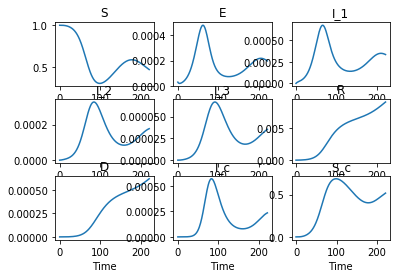

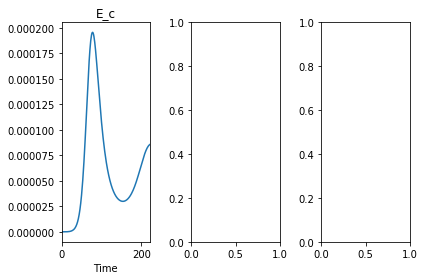

Peak infection (days) 66.0


In [25]:
# setup time points for simulation, initial conditions and parameters
t = np.linspace(0, lastday -1, lastday)
tmax=lastday-1
# initial conditions assuming there is no natural immunity
E_0 =  0.00003
x0_SC3EI3R = [1.0-E_0, E_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
x0_SC3EI3R = [1.0-E_0, E_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# Define parameters based on clinical observations Dr. Alison
Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days
FracMild=0.70  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.07 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=7 #Time from ICU admission to death, days
DurHosp=11 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.125  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.2 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.3 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.002 # Fraction of ICUs relative to population size N


# convert above parameters to model parameters
params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
# assign x0 and params to the model, integrate over t and plot
SC3EI3R_model.initial_values = (x0_SC3EI3R, t[0])
SC3EI3R_model.parameters = params
SC3EI3R_model.params = params.copy()
solution = SC3EI3R_model.integrate(t[1::])

SC3EI3R_model.plot()

# calculate time point when maximum number of people are infectious
peak_i = np.argmax(solution[:,2])
print('Peak infection (days)', t[peak_i])

In [ ]:
x0_SC3EI3R

### Compare data with SC3EI3R simulation

In [ ]:
# model with generating parameters 
params1 = SC3EI3R_model.params.copy()
params1['c_0']=0.35
SC3EI3R_model.parameters = params1
print(SC3EI3R_model.parameters)
x0_fit = x0_SC3EI3R.copy()
# x0_fit[2] = 0.00001
#t_fit = numpy.linspace(0, 150, 1000)
print(x0_fit)
t_fit = t
print(len(t))
SC3EI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SC3EI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
sol_fit =SC3EI3R_model.integrate(t_fit[1::])
# sol_fit = SC3EI3R_model.integrate(t_fit)
# sol_fit = scipy.integrate.odeint(SC3EI3R_model(params_fit).ode, x0_fit, t_fit[1::])
# print(len(sol_fit[0]))
#
plt.figure(figsize=(15,10))
plt.plot(t,y_jhu[test_country][:,1]/FracRecoveredDet, 'bo',label='R') # recovered
plt.plot(t,y_jhu[test_country][:,2]/FracDeathsDet, 'ro',label='D') # died
plt.gca().set_prop_cycle(color=['grey','orange','green','green','green','blue','red','darkgreen', 'black'])
#plt.plot(t_fit[1::], sol_fit)
plt.plot(t_fit, sol_fit)
plt.ylim([0,0.06])
plt.legend()
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

## Simulation models for range of caution parameters

### SCIR, SC2IR, SCEIR, SC3EIR,  SCEI3R, SC3EI3R, SC2UIR, SC3UEIR, SC3UEI3R simulations

In [ ]:
def param_copy(model):
    params = model.parameters
    newparams = {}
    pkeys1 = list(model.params.keys())
    pkeys2 = list(model.parameters.keys())
    for i in range(len(pkeys1)):
        newparams[pkeys1[i]] = params[pkeys2[i]]
    print(newparams)
    model.parameters=newparams
    
def param_modify(model,param,value):
    params = model.parameters
    newparams = {}
    pkeys1 = list(model.params.keys())
    pkeys2 = list(model.parameters.keys())
    for i in range(len(pkeys1)):
        newparams[pkeys1[i]] = params[pkeys2[i]]
    newparams[param]=value
    print(newparams)
    model.parameters=newparams
    
param_modify(SCIR_model,'beta',0.721)

In [ ]:
SCIR_model.parameters = {'gamma':0.4}
SCIR_model.parameters

In [ ]:
def vector2params_old(b,a,g,p,u,c,k,N,modelname):
    if 'I3' in modelname:  # models with hospitalization
        params = {
            'beta_1' : b[1],
            'beta_2' : b[2],
            'beta_3' : b[3],
            'alpha' : a,
            'gamma_1': g[1],
            'gamma_2': g[2],
            'gamma_3': g[3],
            'p_1'    : p[1],
            'p_2'    : p[2],
            'mu'    : u}
    elif 'E' in modelname:
        params = {
            'beta' : b[1],  # see above for explanations
            'alpha' : a, 
            'gamma': g[1]+g[2]*(p[1]/(g[2]+p[2]))+g[3]*(p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u)),
            'mu'    : u*(p[1]/(g[2]+p[2])*(p[2]/(g[3]+u)))}    
    else:
        params = {
            'beta' : b[1],  # see above for explanations
            'gamma': g[1]+g[2]*(p[1]/(g[2]+p[2]))+g[3]*(p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u)),
            'mu'    : u*(p[1]/(g[2]+p[2])*(p[2]/(g[3]+u)))}
            
    if 'C' in modelname: # models with caution  
        params['c_0'] = c[0]
        params['c_1'] = c[1]
        if 'I3' in modelname: # models with hospitalization
            params['c_2'] = c[2]
        else:
            params['c_2'] = c[2]*FracCritical
        
    if 'U' in modelname: # models with economic correction to caution  
        params['k_u'] = k[0]
        params['k_1'] = k[1]
        params['k_w'] = k[2]
        params['kappa'] = k[3]
        
    params['N'] = N
    return params

def params2vector_old(params):
    b = [None,None,None]
    g = [None,None,None]
    p = [None,None,None]
    c = [None,None,None]
    b[0]=0.0
    b[1]=params['beta_1']
    b[2]=params['beta_2']
    b[3]=params['beta_3']
    g[0]=0.0
    g[1]=params['gamma_1']
    g[2]=params['gamma_2']
    g[3]=params['gamma_3']
    p[0]=0.0
    p[1]=params['p_1']
    p[2]=params['p_2']
    c[0]=params['c_1']
    c[1]=params['c_2']
    c[2]=params['c_3']
    a=params['alpha']
    u=params['mu']
    N=params['N']
    return (b,a,g,p,u,c,N)

In [ ]:
def vector2params(b,a,g,p,u,c,k,N,modelname):
    global FracCritical
    if 'I3' in modelname:  # models with hospitalization
        params = {
            'beta_1' : b[1],
            'beta_2' : b[2],
            'beta_3' : b[3],
            'alpha' : a,
            'gamma_1': g[1],
            'gamma_2': g[2],
            'gamma_3': g[3],
            'p_1'    : p[1],
            'p_2'    : p[2],
            'mu'    : u}
    elif 'E' in modelname:
        irat = 1 + p[1]/(g[2]+p[2]) + p[2]/(g[3]+u)
        #irat = 1
        params = {
            'beta' : b[1],  # see above for explanations
            'alpha' : a, 
            'gamma': (g[1]+g[2]*(p[1]/(g[2]+p[2]))+g[3]*(p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u)))/irat,
            'mu'    : u*(p[1]/(g[2]+p[2])*(p[2]/(g[3]+u))/irat)}
    else:
        irat = 1 + p[1]/(g[2]+p[2]) + p[2]/(g[3]+u)
        #irat = 1
        params = {
            #'beta' : np.sqrt(b[1]*a),  # see above for explanations
            'beta' : b[1],  # see above for explanations
            'gamma': (g[1]+g[2]*(p[1]/(g[2]+p[2]))+g[3]*(p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u)))/irat,
            'mu'    : u*(p[1]/(g[2]+p[2])*(p[2]/(g[3]+u))/irat)}
            
    if 'C' in modelname: # models with caution  
        params['c_0'] = c[0]
        params['c_1'] = c[1]
        if 'I3' in modelname: # models with hospitalization
            params['c_2'] = c[2]
        else:
            params['c_2'] = c[2]*FracCritical
        
    if 'U' in modelname: # models with economic correction to caution  
        params['k_u'] = k[0]
        params['k_1'] = k[1]
        params['k_w'] = k[2]
        params['kappa'] = k[3]
        
    params['N'] = N
    return params

def params2vector(params):
    b = [None,None,None]
    g = [None,None,None]
    p = [None,None,None]
    c = [None,None,None]
    b[0]=0.0
    b[1]=params['beta_1']
    b[2]=params['beta_2']
    b[3]=params['beta_3']
    g[0]=0.0
    g[1]=params['gamma_1']
    g[2]=params['gamma_2']
    g[3]=params['gamma_3']
    p[0]=0.0
    p[1]=params['p_1']
    p[2]=params['p_2']
    c[0]=params['c_1']
    c[1]=params['c_2']
    c[2]=params['c_3']
    a=params['alpha']
    u=params['mu']
    N=params['N']
    return (b,a,g,p,u,c,N)

In [ ]:
count = 0

def difference(datain):
    dataout = np.zeros(np.shape(datain))
    for i in range(1,len(datain)):
        dataout[i,...] = datain[i,...]-datain[i-1,...]
    return dataout
        
def rolling_average(datain,period):
    (tmax,n) = np.shape(datain)
    dataout = np.zeros((tmax,n),dtype=float)
    moving_av = np.zeros(n,dtype=float)
    for k in range(len(datain)):
        if k-period >= 0:
            moving_av[:] = moving_av[:] - datain[k-7,...]
        moving_av[:] = moving_av[:] + datain[k,...]
        dataout[k] = moving_av/min(float(period),float(k+1))
    return dataout

axes = [None]
    
def solveplot(smodels=['SIR','SCIR','SC2IR','SEIR','SCEIR','SC3EIR','SEI3R','SCEI3R','SC3EI3R'],species='EI',tmax=100,summing='daily',averaging='weekly',fitdata = None,scale='linear',plottitle= '',label='',
              newplot = True, gbrcolors=False, figsize = None):
    """
    solve ODEs and plot for set of models indicated
    params: dictionary of simulation parameters
    scale: alternative 'linear' or 'log'
    species alternatives 'all', 'EI', 'confirmed', 'deaths', 'daily confirmed', 'daily deaths'
    plottitle : title for plot
    label : label for curve when called as part of multicurve plot
    newplot : whether to open new plot True/False
    models : list of models to include, default all three of those possible
    """
    global count
    global axes
    global FracConfirmedDet,FracRecoveredDet,FracDeathsDet
    tvec=np.arange(0,tmax,1)
    tvec1 = tvec[1:]

    if not fitdata is None:
        tmaxf = len(fitdata)
        if fitdata.ndim != 2:
            print("error in number of dimensions of array")
        else:
            print("fit data ",np.shape(fitdata))
        tvecf=np.arange(0,tmaxf,1)
        tvecf1 = tvecf[1:]
            
    nmodels = len(smodels)
    nm = 0
    
    count = count+1
    
    if newplot:
        axes = [None]*nmodels 
        if (figsize == None):
            figsize=(nmodels*8,6)
        plt.figure(figsize=figsize)
        # fig, axeslist = plt.subplots(1, nmodels, figsize=(nmodels*8,6))
        
    solns = []    
    for smodel in smodels:
        model = cmodels[smodel]
        nm = nm + 1
        soln = scipy.integrate.odeint(model.ode, model.initial_values[0], tvec[1::])
        #Plot
        # ax = axeslist[nm]
        if axes[nm-1] == None: 
            ax = axes[nm-1] = plt.subplot(1,nmodels,nm)
        else:
            ax = axes[nm-1]
        if scale == 'log': #Plot on log scale
            ax.semilogy()
            ax.ylim([0.00000001,1.0])
        if not isinstance(species,list):
            lspecies = [species]
        else:
            lspecies = species
            
        if summing == 'daily':
            ssoln = difference(soln)
            if not fitdata is None:
                sfit = difference(fitdata)
        else:
            ssoln = soln
            if not fitdata is None:
                sfit = fitdata
                
        if averaging == 'weekly':
            srsoln = rolling_average(ssoln,7)
            if not fitdata is None:
                srfit = rolling_average(sfit,7)
        else:
            srsoln = ssoln
            if not fitdata is None:
                srfit = sfit
                
        for species in lspecies:
            if species == 'confirmed':
                suma = np.sum(srsoln[:,model.confirmed],axis=1)
                if not fitdata is None:
                    ax.plot(tvec1,suma,label=label,color='green')
                    fita = srfit[1::,0]/FracConfirmedDet # confirmed cases data, corrected by FracConfirmedDet
                    ax.plot(tvecf1,fita,'o',label=label,color='green')
                else:
                    ax.plot(tvec1,suma,label=label)
            if species == 'recovered':
                suma = np.sum(srsoln[:,model.recovered],axis=1)   
                if not fitdata is None:
                    ax.plot(tvec1,suma,label=label,color='blue')
                    fita = srfit[1::,1]/FracRecoveredDet # recovered cases data, corrected by FracRecoveredDet
                    ax.plot(tvecf1,fita,'o',label=label,color='blue')
                else:
                    ax.plot(tvec1,suma,label=label)
            elif species == 'deaths':
                suma = np.sum(srsoln[:,model.deaths],axis=1)
                if not fitdata is None:
                    ax.plot(tvec1,suma,label=label,color='red')
                    fita = srfit[1::,2]/FracDeathsDet # deaths cases data, corrected by FracDeathsDet
                    ax.plot(tvecf1,fita,'o',label=label,color='red')
                else:
                    ax.plot(tvec1,suma,label=label)
            elif species == 'deaths_x10':
                suma = np.sum(srsoln[:,model.deaths],axis=1)*10
                if not fitdata is None:
                    ax.plot(tvec1,suma,label=label,color='red')
                    fita = srfit[1::,2]*10/FracDeathsDet # deaths cases data, corrected by FracDeathsDet
                    ax.plot(tvecf1,fita,'o',label=label,color='red')
                else:
                    ax.plot(tvec1,suma,label=label)
            elif species == 'EI':
                ax.plot(tvec1,soln[:,model.ei],label=label)
                # ax.plot(tvec1,soln[:,model.ei],label="%s" % count)
                if 'I3' in model.modelname: 
                    plt.legend(("E","I1","I2","I3"))
                elif 'E' in model.modelname: 
                    plt.legend(("E","I"))
                else:
                    plt.legend(("I"))
            elif species == 'all':
                ax.plot(tvec1,soln,label=label)

                if 'I3' in model.modelname:
                    if 'C3'in model.modelname:
                        pspecies=("S","E","I1","I2","I3","R","D","Ic","Sc","Ec")
                    elif 'C' in model.modelname:
                        pspecies=("S","E","I1","I2","I3","R","D","Sc")
                    else:
                        pspecies=("S","E","I1","I2","I3","R","D")
                elif 'E' in model.modelname:
                    if 'C3'in model.modelname:
                        pspecies=("S","E","I","R","D","Ic","Sc","Ec")
                    else:
                        pspecies=("S","E","I","R","D","Sc")                
                else:
                    if 'C2'in model.modelname:
                        pspecies=("S","I","R","D","Ic","Sc")
                    else:
                        pspecies=("S","I","R","D","Sc")
                plt.legend(pspecies)
            
        plt.xlabel("Time (days)")
        plt.ylabel("Fraction of population")
        plt.title(model.modelname +' '+plottitle)
        solns.append(soln)
    return solns

In [ ]:
# Set up multimodel consistent sets of parameters
Exposure=0.25     # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5     #Incubation period, days 
DurMildInf=10     #Duration of mild infections, days
FracMild=0.8      #Fraction of infections that are mild
FracSevere=0.15   #Fraction of infections that are severe
FracCritical=0.05 #Fraction of infections that are critical
CFR=0.02          #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=7    #Time from ICU admission to death, days
DurHosp=11        #Duration of hospitalization, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.3    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 14. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.25  # Fraction of ICUs occupied leading to 90% of susceptibles in caution 
ICUFrac= 0.001        # Fraction of ICUs relative to population size N

EconomicCostOfCaution = 0.5 # Cost to economy of individual exercising caution

N=1
b=np.zeros(4)     # beta
g=np.zeros(4)     # gamma
p=np.zeros(3)     # progression
c=np.zeros(3)     # caution
k=np.zeros(4)     # economic caution

a=1/IncubPeriod                       # transition rate from exposed to infected
b=Exposure*np.array([0,1,0,0])/N      # hospitalized cases don't transmit
u=(1/TimeICUDeath)*(CFR/FracCritical) # death rate from ICU
g[3]=(1/TimeICUDeath)-u               # recovery rate

p[2]=(1/DurHosp)*(FracCritical/(FracCritical+FracSevere))
g[2]=(1/DurHosp)-p[2]

g[1]=(1/DurMildInf)*FracMild
p[1]=(1/DurMildInf)-g[1]

c[0]=CautionFactor
c[1]=1/CautionRetention
c[2]=1/(N*ICUFrac*CautionICUFrac)     # this is the rate coefficient giving 1/day at I3 = denominator

k[0]=c[1]
k[1]=c[1]
k[2]=c[1]
k[3]=EconomicCostOfCaution

cmodels = {'SIR':SIR_model,'SCIR':SCIR_model,'SC2IR':SC2IR_model,
           'SEIR':SEIR_model,'SCEIR':SCEIR_model,'SC3EIR':SC3EIR_model,
           'SEI3R':SEI3R_model,'SCEI3R':SCEI3R_model,'SC3EI3R':SC3EI3R_model,
           'SC2UIR':SC2UIR_model,'SC3UEIR':SC3UEIR_model,'SC3UEI3R':SC3UEI3R_model}
smodels = ['SIR','SCIR','SC2IR','SEIR','SCEIR','SC3EIR','SEI3R','SCEI3R','SC3EI3R','SC2UIR','SC3UEIR','SC3UEI3R']

for smodel in smodels: 
    params_in=vector2params(b,a,g,p,u,c,k,N,smodel)
    # print(smodel,params_in)
    cmodels[smodel].parameters = params_in
    
I_0 =  0.00003

x0_SIR = [1.0-I_0, I_0, 0.0, 0.0]
x0_SCIR = [1.0-I_0, I_0, 0.0, 0.0, 0.0]
x0_SC2IR = [1.0-I_0, I_0, 0.0, 0.0, 0.0, 0.0]
SIR_model.initial_values = (x0_SIR, t[0])
SCIR_model.initial_values = (x0_SCIR, t[0])
SC2IR_model.initial_values = (x0_SC2IR, t[0])

x0_SEIR = [1.0-I_0, 0.0, I_0, 0.0, 0.0]
x0_SCEIR = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0]
x0_SC3EIR = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0]
SEIR_model.initial_values = (x0_SEIR, t[0])
SCEIR_model.initial_values = (x0_SCEIR, t[0])
SC3EIR_model.initial_values = (x0_SC3EIR, t[0])

x0_SEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0]
x0_SCEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0]
x0_SC3EI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
SEI3R_model.initial_values = (x0_SEI3R, t[0])
SCEI3R_model.initial_values = (x0_SCEI3R, t[0])
SC3EI3R_model.initial_values = (x0_SC3EI3R, t[0])


x0_SC2UIR = [1.0-I_0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
x0_SC3UEIR = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
x0_SC3UEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
SC2UIR_model.initial_values = (x0_SC2UIR, t[0])
SC3UEIR_model.initial_values = (x0_SC3UEIR, t[0])
SC3UEI3R_model.initial_values = (x0_SC3UEI3R, t[0])

In [ ]:
import os
os.getcwd()

In [ ]:
smodels1 = ['SIR','SEIR','SEI3R']
smodels2 = ['SC2IR','SC3EIR','SC3EI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.2    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.8,0.7,0.6,0.5]   # Fractional reduction of exposure rate for cautioned individuals
CautionFactors2= [0.5,0.4,0.3,0.2,0.1,0.0]     # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.]      # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 

import os
cwd=os.getcwd()

newplot = True  
for smodel in smodels1:
    model = cmodels[smodel]
label_c = '' 
plottitle = 'Without Caution' 
solns=solveplot(smodels1,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)

irat = 1 + p[1]/(g[2]+p[2]) + p[2]/(g[3]+u)
drat = (p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u))/irat

newplot = True
for s in range(6):
    for smodel in smodels2:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
                
    label_c = 'CautionFactor %s' % CautionFactors[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels2,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False  
plt.savefig(cwd+"/figures/fig3a.pdf",bbox_inches='tight')

newplot = True
for s in range(6):
    for smodel in smodels2:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactors2[s],'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
                
    label_c = 'CautionFactor %s' % CautionFactors2[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels2,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False  
plt.savefig(cwd+"/figures/fig3b.pdf",bbox_inches='tight')

newplot = True
#for i in reversed(range(5)):
for s in range(6):
    for smodel in smodels2:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s]}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionRetention %s'% CautionRetentions[s]
    plottitle = 'Caution Retention' 
    solns=solveplot(smodels2,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
plt.savefig(cwd+"/figures/fig3c.pdf",bbox_inches='tight')

newplot = True    
for s in range(6):
    for smodel in smodels2:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s]}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFracs[s])}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFracs[s])}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFracs[s])}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionICUFrac %s'% CautionICUFracs[s]
    plottitle = 'Caution ICUFrac' 
    solns=solveplot(smodels2,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False

plt.savefig(cwd+"/figures/fig3d.pdf",bbox_inches='tight')

# return parameters to standard set
for smodel in smodels2:
    model = cmodels[smodel]
    if 'C' in model.modelname:
        cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}
        


In [ ]:
smodels = ['SCIR','SC2IR','SCEIR','SC3EIR','SCEI3R','SC3EI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.2    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.8,0.7,0.6,0.5]         # Fractional reduction of exposure rate for cautioned individuals
CautionFactors2= [0.5,0.4,0.3,0.2,0.1,0.0]        # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.]     # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 

irat = 1 + p[1]/(g[2]+p[2]) + p[2]/(g[3]+u)
drat = (p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u))/irat

newplot = True
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
                
    label_c = 'CautionFactor %s' % CautionFactors[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False  
#plt.savefig(cwd+"/figures/fig3sa.pdf",bbox_inches='tight')

newplot = True
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactors2[s],'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
                
    label_c = 'CautionFactor %s' % CautionFactors2[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False  
#plt.savefig(cwd+"/figures/fig3sb.pdf",bbox_inches='tight')

newplot = True
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s]}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionRetention %s'% CautionRetentions[s]
    plottitle = 'Caution Retention' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
#plt.savefig(cwd+"/figures/fig3sc.pdf",bbox_inches='tight')

newplot = True    
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s]}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFracs[s])}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFracs[s])}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFracs[s])}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionICUFrac %s'% CautionICUFracs[s]
    plottitle = 'Caution ICUFrac' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False

#plt.savefig(cwd+"/figures/fig3sd.pdf",bbox_inches='tight')

# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
        cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}

In [ ]:
smodels = ['SCEIR','SC3EIR','SCEI3R','SC3EI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.25    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 45. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.05   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.75,0.5,0.25,0.0]   # Fractional reduction of exposure rate for cautioned individuals
CautionFactors2= [0.4,0.3,0.2,0.1,0.0]   # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.]      # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 

newplot = True
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            if 'E' in model.modelname:
                cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}
            else:
                cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention,'c_2':FracSevere*FracCritical/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
        else:
            print("ERROR")
    label_c = 'CautionFactor %s' % CautionFactors[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False

newplot = True
for s in range(5):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            if 'E' in model.modelname:
                cmodels[smodel].parameters = {'c_0':CautionFactors2[s],'c_1':1./CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}
            else:
                cmodels[smodel].parameters = {'c_0':CautionFactors2[s],'c_1':1./CautionRetention,'c_2':FracSevere*FracCritical/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
        else:
            print("ERROR")
    label_c = 'CautionFactor %s' % CautionFactors2[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
    
newplot = True
#for i in reversed(range(5)):
for s in range(5):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            if 'E' in model.modelname:
                cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s],'c_2':1./(N*ICUFrac*CautionICUFrac)}
            else:
                cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s],'c_2':FracSevere*FracCritical/(N*ICUFrac*CautionICUFrac)}
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetentions[s],'c_2':1./(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionRetention %s'% CautionRetentions[s]
    plottitle = 'Caution Retention' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False

newplot = True    
for s in range(5):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFracs[s])}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionICUFrac %s'% CautionICUFracs[s]
    plottitle = 'Caution ICUFrac' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
    
# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
        cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}

In [ ]:
smodels = ['SCIR','SC2IR','SCEIR','SC3EIR','SCEI3R','SC3EI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.2    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.75,0.5,0.25,0.0]   # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.]      # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 



newplot = True
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            if 'E' in model.modelname:
                cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}
            else:
                cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention,'c_2':FracSevere*FracCritical/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
        else:
            print("ERROR")
    label_c = 'CautionFactor %s' % CautionFactors[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False

newplot = True
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            if 'E' in model.modelname:
                cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s],'c_2':1./(N*ICUFrac*CautionICUFrac)}
            else:
                cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s],'c_2':FracSevere*FracCritical/(N*ICUFrac*CautionICUFrac)}
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetentions[s],'c_2':1./(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionRetention %s'% CautionRetentions[s]
    plottitle = 'Caution Retention' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False

newplot = True    
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFracs[s])}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionICUFrac %s'% CautionICUFracs[s]
    plottitle = 'Caution ICUFrac' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
    
# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
        cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}

In [ ]:
# smodels = ['SC2IR','SC2UIR','SC3EIR','SC3UEIR','SC3EI3R','SC3UEI3R']
smodels = ['SC2UIR','SC3UEIR','SC3UEI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.4    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.8,0.7,0.6,0.5]         # Fractional reduction of exposure rate for cautioned individuals
CautionFactors2= [0.5,0.4,0.3,0.2,0.1,0.0]        # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.].reverse()     # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 
ktime = 56.
ktimes= [1., 7.,14.,28.,56.,112.]   # Duration of cautionary state of susceptibles
kappas = [1.,0.8,0.6,0.4,0.2,0.]    # Economic cost of caution
kappa = 0.5
irat = 1 + p[1]/(g[2]+p[2]) + p[2]/(g[3]+u)
drat = (p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u))/irat  

newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktime,'kappa':kappas[s]}          
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'kappa %s' % kappas[s]
    plottitle = 'Cost of caution kappa' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False 
plt.savefig(cwd+"/figures/fig5sa.pdf",bbox_inches='tight')

newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktimes[s],'k_1':1./ktime,'k_w':1./ktime, 'kappa':kappa}           
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'k_u time %s' % ktimes[s]
    plottitle = 'Uncautionable decay k_u' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False     
plt.savefig(cwd+"/figures/fig5sb.pdf",bbox_inches='tight')
    
newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktimes[s],'k_w':1./ktime, 'kappa':kappa}          
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'k_1 time %s' % ktimes[s]
    plottitle = 'Uncautionable decay k_1' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False   
plt.savefig(cwd+"/figures/fig5sc.pdf",bbox_inches='tight')
    
newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktimes[s], 'kappa':kappa}  
    if s == -1:
        label_c = 'no economic influence'
    else:        
        label_c = 'k_w time %s' % ktimes[s]
    plottitle = 'Economic relaxation k_w' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False    
plt.savefig(cwd+"/figures/fig5sd.pdf",bbox_inches='tight')
    
# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
    if 'U' in model.modelname:
            cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktime, 'kappa':kappa}

In [ ]:
# smodels = ['SC2IR','SC2UIR','SC3EIR','SC3UEIR','SC3EI3R','SC3UEI3R']
smodels = ['SC2UIR','SC3UEIR','SC3UEI3R']
# tmax = lastday-1
tmax = 600
# caution standard parameters
CautionFactor= 0.2    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.8,0.7,0.6,0.5]         # Fractional reduction of exposure rate for cautioned individuals
CautionFactors2= [0.5,0.4,0.3,0.2,0.1,0.0]        # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.].reverse()     # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 
ktime = 56.
ktimes= [1., 7.,14.,28.,56.,112.]   # Duration of cautionary state of susceptibles
kappas = [1.,0.8,0.6,0.4,0.2,0.]    # Economic cost of caution
kappa = 0.5
irat = 1 + p[1]/(g[2]+p[2]) + p[2]/(g[3]+u)
drat = (p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u))/irat  

newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktime,'kappa':kappas[s]}          
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'kappa %s' % kappas[s]
    plottitle = 'Cost of caution kappa' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False 
plt.savefig(cwd+"/figures/fig6sa.pdf",bbox_inches='tight')

newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktimes[s],'k_1':1./ktime,'k_w':1./ktime, 'kappa':kappa}           
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'k_u time %s' % ktimes[s]
    plottitle = 'Uncautionable decay k_u' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False     
plt.savefig(cwd+"/figures/fig6sb.pdf",bbox_inches='tight')
    
newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktimes[s],'k_w':1./ktime, 'kappa':kappa}          
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'k_1 time %s' % ktimes[s]
    plottitle = 'Uncautionable decay k_1' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False   
plt.savefig(cwd+"/figures/fig6sc.pdf",bbox_inches='tight')
    
newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktimes[s], 'kappa':kappa}  
    if s == -1:
        label_c = 'no economic influence'
    else:        
        label_c = 'k_w time %s' % ktimes[s]
    plottitle = 'Economic relaxation k_w' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False    
plt.savefig(cwd+"/figures/fig6sd.pdf",bbox_inches='tight')
    
# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
    if 'U' in model.modelname:
            cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktime, 'kappa':kappa}

In [ ]:
smodels = ['SC3UEI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.4    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.8,0.7,0.6,0.5]         # Fractional reduction of exposure rate for cautioned individuals
CautionFactors2= [0.5,0.4,0.3,0.2,0.1,0.0]        # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.].reverse()     # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 
ktime = 56.
ktimes= [2.5, 5.,10.,20.,40.,80.]   # Duration of cautionary state of susceptibles
kappas = [1.,0.8,0.6,0.4,0.2,0.]    # Economic cost of caution
kappa = 0.5
irat = 1 + p[1]/(g[2]+p[2]) + p[2]/(g[3]+u)
drat = (p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u))/irat  

newplot = True
for s in range(-1,6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
        else:
            print("ERROR")
        if 'U' in smodel:
            if s == -1:
                cmodels[smodel].parameters = {'k_u':0.,'k_1':1.,'k_w':1.,'kappa':0.}  
            else:
                cmodels[smodel].parameters = {'k_u':1./ktimes[s],'k_1':1./90.,'k_w':1./90., 'kappa':kappa}           
    if s == -1:
        label_c = 'no economic influence'
    else:
        label_c = 'k_u 1/%s' % ktimes[s]
    plottitle = 'Uncautionable decay k_u' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False     
#plt.savefig(cwd+"/figures/fig5a.pdf",bbox_inches='tight')

    
# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention}
            if 'E' in model.modelname:
                if 'I3' in model.modelname:
                    cmodels[smodel].parameters = {'c_2':1./(N*ICUFrac*CautionICUFrac)}
                else:
                    cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}  
            else:
                cmodels[smodel].parameters = {'c_2':drat/(N*ICUFrac*CautionICUFrac)}
    if 'U' in model.modelname:
            cmodels[smodel].parameters = {'k_u':1./ktime,'k_1':1./ktime,'k_w':1./ktime, 'kappa':kappa}

In [ ]:
# more extensive parameter screen for one model
smodels = ['SCEI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.2    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.5,0.1]       # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,28.,112.]    # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFracs= [0.0625,0.25,0.75] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 

for s2 in range(3):
 newplot = True
 for s3 in range(3):
   newplot = True
   for s1 in range(3):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname: 
            cmodels[smodel].parameters = {'c_0':CautionFactors[s1],'c_1':1./CautionRetentions[s2],'c_2':1./(N*ICUFrac*CautionICUFracs[s3])}
        else:
            print("ERROR")
    label_c = ('CF %s' % CautionFactors[s1]) + (' CICUF %s'% CautionICUFracs[s3])
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
    
# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
        cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}


In [ ]:
# the parameters are stored not as strings but as sympy symbols
# but they cannot be accessed externally like that
# from sympy import Symbol
# cmodels['SCIR'].parameters[Symbol('c_0')]  # prouces KeyError: c_0
types= [type(k) for k in cmodels['SCIR'].parameters.keys()]
print(types)

# Parameter fitting

## Fitting via sliders

### SC3EIR Model

In [ ]:
len(t)

In [ ]:
model = 'SC3EIR'
params={'beta':0.25,'alpha':1./5.,'gamma':0.1,'mu':0.05,'c_0':0.3, 'c_1':1/14., 'c_2':2000}
def slidefitplot(beta,alpha,gamma,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta':beta, 'alpha':alpha, 'gamma':gamma, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.]
    cmodels[model].initial_values = (x0,t[0])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths'],tmax=len(t),summing='daily',fitdata=y_jhu[test_country],scale='linear',plottitle= '',label='confirmed',newplot = True)

In [ ]:
interact(slidefitplot,
         beta=FloatSlider(min=0,max=1,step=0.01,value=params['beta'],description='beta',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         gamma=FloatSlider(min=0,max=1,step=0.01,value=params['gamma'],description='gamma',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False))

### SC3EI3R Model

#### Germany

In [ ]:
# assumed data starting on firstdate
test_country='Germany'
N = 80000000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
len(t)

In [ ]:
(1.0/TimeICUDeath)*(CFR/FracCritical)

In [ ]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days  : includes time for reg. of recovery
FracMild=0.7  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.05 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=5 #Time from ICU admission to death, days
DurHosp=4 #Duration of hospitalization, days  : includes 4 day reg of recovery

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=1.0  # Fraction of recovered individuals measured : plots made with this parameter NYI
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
SC3EI3R_model.parameters = params

def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.,0.]
    #x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]


    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

In [ ]:
params=w.kwargs

print(params)

#### Spain

In [ ]:
# assumed data starting on firstdate
test_country='Spain'
N = 80000000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
len(t)

In [ ]:
(1.0/TimeICUDeath)*(CFR/FracCritical)

In [ ]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days  : includes time for reg. of recovery
FracMild=0.7  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.05 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=5 #Time from ICU admission to death, days
DurHosp=4 #Duration of hospitalization, days  : includes 4 day reg of recovery

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of confirmed individuals measured : plots made with this parameter NYI
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
SC3EI3R_model.parameters = params

def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.,0.]
    #x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]


    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

In [ ]:
params=w.kwargs

print(params)

#### Italy

In [ ]:
# assumed data starting on firstdate
test_country='Italy'
N = 66650000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=4 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of infected individuals confirmed
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
SC3EI3R_model.parameters = params

def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.,0.]
    # x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]


    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

In [ ]:
params=w.kwargs

print(params)

Note that we have used 50% detection of confirmed and recovered, 100% for deaths in manual fit. 
It appears that Italy's registration of recovery, although the right overall magnitude is markedly delayed - check reporting delays.
Italy also had at least two successive regional infections, as seen in the dual peak confirmed data, so not easy to fit with one model.
See below for simulation of second peak.

In [ ]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

#### Brazil

In [ ]:
# assumed data starting on firstdate
test_country='Brazil'
N = 210000000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=8 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
SC3EI3R_model.parameters = params

def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.,0.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='cumulative',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

The Brazil data shows that death is not as delayed as assumed. The process of progression is perhaps less clearly documented.

#### Russia

In [ ]:
# assumed data starting on firstdate
test_country='Iran'
N = 144500000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=8 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.002 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
SC3EI3R_model.parameters = params

def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.,0.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='cumulative',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

### SC3UEIR Model

In [ ]:
# assumed data starting on firstdate
test_country='US'
N = 66650000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
model = 'SC3UEIR'
I_0 =  0.00003
x0_SC3UEIR = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
SC3UEIR_model.initial_values = (x0_SC3UEIR, t[0])

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=8 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

# Model extension by John McCaskill to include economic influence on caution 
EconomicCostOfCaution= 0.5 # Fractional reduction of economic contribution for cautioned individuals

p = [0,(1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,  (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere))]
g = [0,(1.0/DurMildInf)*FracMild,   (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
           (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical)]
u = (1.0/TimeICUDeath)*(CFR/FracCritical)
                
params = {'beta' : Exposure/sum(x0_SC3UEIR),
          'alpha' : 1.0/IncubPeriod,
          'gamma' :  g[1]+g[2]*(p[1]/(g[2]+p[2]))+g[3]*(p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u)),
          'mu'     : u*(p[1]/(g[2]+p[2])*(p[2]/(g[3]+u))),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3UEIR)*ICUFrac*CautionICUFrac),
          'N'      : sum(x0_SC3UEIR),
          'k_u'    : 1.0/CautionRetention,
          'k_1'    : 1.0/CautionRetention,
          'k_w'    : 1.0/CautionRetention,
          'kappa'  : EconomicCostOfCaution}

print(params)
SC3UEIR_model.parameters = params.copy()
# solution = SCIR_model.integrate(t[1::])

def slidefitplot(beta,alpha,gamma,mu,c_0,c_1,c_2,logI_0,k_u,k_1,k_w,kappa):
    params={ 'beta':beta, 'alpha':alpha, 'gamma':gamma, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2, 'k_u':k_u, 'k_1':k_1, 'k_w':k_w, 'kappa':kappa}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,1.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w = interactive(slidefitplot,
         beta=FloatSlider(min=0,max=1,step=0.01,value=params['beta'],description='beta',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         gamma=FloatSlider(min=0,max=1,step=0.01,value=params['gamma'],description='gamma',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False),
         k_u=FloatSlider(min=0,max=1,step=0.001,value=params['k_u'],description='k_u',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_1=FloatSlider(min=0,max=1,step=0.001,value=params['k_1'],description='k_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_w=FloatSlider(min=0,max=1,step=0.001,value=params['k_w'],description='k_w',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         kappa=FloatSlider(min=0,max=1,step=0.001,value=params['kappa'],description='kappa',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'))
display(w)

In [ ]:
params=w.kwargs
# not a good fit yet, did better last week
print(params)

### SC3UEI3R Model

#### USA

In [ ]:
# assumed data starting on firstdate
test_country='US'
N = 66650000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
model = 'SC3UEI3R'
I_0 =  0.00003
x0_SC3UEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
SC3UEI3R_model.initial_values = (x0_SC3UEI3R, t[0])

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=5 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

# Model extension by John McCaskill to include economic influence on caution 
EconomicCostOfCaution= 0.5 # Fractional reduction of economic contribution for cautioned individuals

p = [0,(1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,  (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere))]
g = [0,(1.0/DurMildInf)*FracMild,   (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
           (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical)]
u = (1.0/TimeICUDeath)*(CFR/FracCritical)
                
params = {'beta_1' : Exposure/sum(x0_SC3UEI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(ICUFrac*CautionICUFrac),
          'k_u'    : 1.0/5.,
          'k_1'    : 1.0/90,
          'k_w'    : 1.0/90,
          'kappa'  : EconomicCostOfCaution,
          'N'      : sum(x0_SC3UEI3R)}

print(params)
SC3UEI3R_model.parameters = params.copy()

In [ ]:
def slidefitplot(beta_1,alpha,mu,c_0,c_1,c_2,logI_0,k_u,k_1,k_w,kappa):
    params={ 'beta_1':beta_1, 'alpha':alpha, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2, 'k_u':k_u, 'k_1':k_1, 'k_w':k_w, 'kappa':kappa}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.,0.,1.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w=interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False),
         k_u=FloatSlider(min=0,max=1,step=0.001,value=params['k_u'],description='k_u',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_1=FloatSlider(min=0,max=1,step=0.001,value=params['k_1'],description='k_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_w=FloatSlider(min=0,max=1,step=0.001,value=params['k_w'],description='k_w',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         kappa=FloatSlider(min=0,max=1,step=0.001,value=params['kappa'],description='kappa',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'))
display(w)

In [ ]:
params=w.kwargs

print(params)

#### Spain

In [ ]:
# assumed data starting on firstdate
test_country='Spain'
N = 66650000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

In [ ]:
model = 'SC3UEI3R'
I_0 =  0.00003
x0_SC3UEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
SC3UEI3R_model.initial_values = (x0_SC3UEI3R, t[0])

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=5 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

# Model extension by John McCaskill to include economic influence on caution 
EconomicCostOfCaution= 0.5 # Fractional reduction of economic contribution for cautioned individuals

p = [0,(1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,  (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere))]
g = [0,(1.0/DurMildInf)*FracMild,   (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
           (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical)]
u = (1.0/TimeICUDeath)*(CFR/FracCritical)
                
params = {'beta_1' : Exposure/sum(x0_SC3UEI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(ICUFrac*CautionICUFrac),
          'k_u'    : 1.0/5.,
          'k_1'    : 1.0/90,
          'k_w'    : 1.0/90,
          'kappa'  : EconomicCostOfCaution,
          'N'      : sum(x0_SC3UEI3R)}

print(params)
SC3UEI3R_model.parameters = params.copy()

In [ ]:
def slidefitplot(beta_1,alpha,mu,c_0,c_1,c_2,logI_0,k_u,k_1,k_w,kappa):
    params={ 'beta_1':beta_1, 'alpha':alpha, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2, 'k_u':k_u, 'k_1':k_1, 'k_w':k_w, 'kappa':kappa}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.,0.,1.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w=interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False),
         k_u=FloatSlider(min=0,max=1,step=0.001,value=params['k_u'],description='k_u',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_1=FloatSlider(min=0,max=1,step=0.001,value=params['k_1'],description='k_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_w=FloatSlider(min=0,max=1,step=0.001,value=params['k_w'],description='k_w',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         kappa=FloatSlider(min=0,max=1,step=0.001,value=params['kappa'],description='kappa',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'))
display(w)

In [ ]:
params=w.kwargs

print(params)

## Fit SC3EI3R parameters to jhu data based on square_loss

### Fit c_0 , c_1 and c_2 as well as initial value of I_1

In [ ]:
SC3EI3R_model.parameters

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
I0 =10**-6.43
x0_SC3EI3R = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.,0.]
SC3EI3R_model.parameters={'beta_1': 0.41, 'mu': 0.079, 'c_0': 0.1, 'c_1': 0.030303030303030304, 'c_2': 11170.0}
cautionparams = list(params.values())[-4:-1]
theta = [0.1,0.07,8000.] # cautionparams
boxBounds = [(0.05,0.4),(0.05,0.15),(1000.,200000.)]
# set up optimization function with cost and sensitivity (Jacobian)
objSC3EI3R = SquareLoss(theta=theta, ode=SC3EI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=y_jhu[test_country][1::,:],
                      state_weight=[1.,1.,10.],state_name=['C_f','R','D'],
                      target_param=['c_0','c_1','c_2'],target_state=['I_1'])
# perform optimization
res = minimize(fun=objSC3EI3R.costIV,
                jac=objSC3EI3R.sensitivityIV,
                x0=theta+[I0],
                bounds=boxBounds+[(0.0000001,0.0001)],
                #method='BFGS',
                method='SLSQP',
                #options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
                #options={'disp':True})
                options={'disp':True,'maxiter':1000,'eps':0.001,'ftol':0.001})
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SC3EI3R)
params_fit = params.copy()
#params_fit['c_0'] = res.x[0]
#params_fit['c_1'] = res.x[1]

SC3EI3R_model.params = params_fit
print(SC3EI3R_model.params)
#ode_fit = common_models.SEI3R({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0_SC3EI3R.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SC3EI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SC3EI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'o',color='lightgreen') # infected observations
plt.plot(t,ynoise[:,1], 'o',color='green') # infected observations
plt.plot(t,ynoise[:,2], 'o',color='darkgreen') # infected observations
plt.plot(t,ynoise[:,3], 'bo') # recoverd
plt.plot(t,ynoise[:,4], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

## Testing fitting

### Generate test data based on SCEI3R simulation

In [ ]:
# Add noise
y = solution[:,2:7].copy()
#print('len(y)',len(y),'t',len(t),t[0],t[1],'...',t[-1])
np.random.seed(seed=6)
noise = np.random.normal(0,1.e-2,[len(t),5])
# ynoise = y *(1+noise)
ynoise = y *(1.0 + noise)
ynoise[ynoise<0] = 0
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go', label='I_1') 
plt.plot(t,ynoise[:,1], 'go', label='I_2') 
plt.plot(t,ynoise[:,2], 'go', label='I_3') 
plt.plot(t,ynoise[:,3], 'bo', label='R') 
plt.plot(t,ynoise[:,4], 'ro', label='D') 
plt.plot(t,y[:,0], 'g', label='I_1') 
plt.plot(t,y[:,1], 'g', label='I_2') 
plt.plot(t,y[:,2], 'g', label='I_3') 
plt.plot(t,y[:,3], 'b', label='R') 
plt.plot(t,y[:,4], 'r', label='D') 
plt.legend()
plt.ylim(0,0.003)
plt.show()

In [ ]:
# model with generating parameters 
print(params)
params_fit = params.copy()
print(params_fit['c_0'],params_fit['c_1'])
SCEI3R_model.params = params_fit

x0_fit = x0_SCEI3R.copy()
print(x0_fit)
#t_fit = numpy.linspace(0, 150, 1000)

t_fit = t
SCEI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
sol_fit = scipy.integrate.odeint(SCEI3R_model.ode, x0_fit, t_fit[1::])
# print(len(sol_fit[0]))
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go',label='I_1') # infected observations
plt.plot(t,ynoise[:,1], 'go',label='I_2') # infected observations
plt.plot(t,ynoise[:,2], 'go',label='I_3') # infected observations
plt.plot(t,ynoise[:,3], 'bo',label='R') # recoverd
plt.plot(t,ynoise[:,4], 'ro',label='D') # died
plt.gca().set_prop_cycle(color=['grey','orange','green','green','green','blue','red', 'black'])
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
plt.legend()
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

In [ ]:
params # use list(...) to convert to list

### Fit parameters to randomized simulation data based on square_loss

#### Fit c_0 and c_1 only

In [ ]:
# Initial guess of parameters, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [value for value in cautionparams]
theta = [0.21,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.0,1.0],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'])
# perform optimization
res = minimize(fun=objSCEI3R.cost,
                jac=objSCEI3R.sensitivity,
                x0=theta,
                #bounds=boxBounds,
                method='BFGS',
                options={'disp':True,'maxiter':1000,'eps':0.00001})# ,'ftol':0.01})  #not BFGS
print(res)

#### Fit c_0 and c_1 as well as initial value of E

##### Fit c_0 and c_1 as well as initial value of E with 'SLSQP'
does not work well
note use of special methods IV for initial value fitting of target_state

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='SLSQP',
                options={'disp':True,'maxiter':1000,'eps':0.01,'ftol':0.01})
print(res)

##### Fit c_0 and c_1 as well as initial value of E with BFGS
works well:  no constraints and gtol not ftol

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='BFGS',
                options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SCEI3R)
params_fit = params.copy()
#params_fit['c_0'] = res.x[0]
#params_fit['c_1'] = res.x[1]

SCEI3R_model.params = params_fit
print(SCEI3R_model.params)
#ode_fit = common_models.SEI3R({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SCEI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SCEI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go') # infected observations
plt.plot(t,ynoise[:,1], 'go') # infected observations
plt.plot(t,ynoise[:,2], 'go') # infected observations
plt.plot(t,ynoise[:,3], 'bo') # recoverd
plt.plot(t,ynoise[:,4], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

##### Fit c_0 and c_1 as well as initial value of E using L-BFGS-B
this method does not work well

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                bounds=boxBounds+[(0.0000001,0.001)],
                method='L-BFGS-B',
                options={'disp':True,'maxiter':1000,'eps':0.0001,'ftol':0.001})
print(res)

In [ ]:
objSCEI3R.residual()

##### Fit c_0 and c_1 as well as initial value of E with Nelder-Mead
no use of Jacobian and no constraints

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                #jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='Nelder-Mead',
                options={'disp':True,'maxiter':1000}) #,'eps':0.0001,'ftol':0.01}) #not NM
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SCEI3R)
params_fit = params.copy()
#params_fit['c_0'] = res.x[0]
#params_fit['c_1'] = res.x[1]

SCEI3R_model.params = params_fit
print(SCEI3R_model.params)
#ode_fit = common_models.SEI3R({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0_SCEI3R.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SCEI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SCEI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go') # infected observations
plt.plot(t,ynoise[:,1], 'go') # infected observations
plt.plot(t,ynoise[:,2], 'go') # infected observations
plt.plot(t,ynoise[:,3], 'bo') # recoverd
plt.plot(t,ynoise[:,4], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

## Fit SC2IR parameters to jhu data based on square_loss

In [ ]:
params=SC2IR_model.parameters
print(params)

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
theta = [0.4,0.11,0.007,0.33,0.228,275.]
boxBounds = [(0.2,0.5),(0.05,0.15),(0.005,0.015),(0.25,0.55),(0.15,0.4),(5.,2000.)]
# setup cost function and Jacobian with target parameters and initial states
objSC2IR = SquareLoss(theta=theta, ode=SC2IR_model, x0=x0, t0=t[0], t=t[1::], y=y_jhu[test_country][1::,1:3],
                      state_weight=[0.2,1.],state_name=['R','D'],
                      target_param=['beta','gamma','mu','c_0','c_1','c_2'],
                      target_state=['I'])
# perform optimization
res = minimize(fun=objSC2IR.costIV,
                jac=objSC2IR.sensitivityIV,
                x0=theta+[0.000000001],
                bounds=boxBounds+[(0.0000000001,0.000001)],
                # method='L-BFGS-B',
                # method='Nelder-Mead',
                #options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
                options={'disp':True,'maxiter':1000,'eps':0.000001,'ftol':0.000000001})
print(res)

In [ ]:
# model with fitted parameters 
startparams = SC2IR_model.parameters.copy()  # save starting parameters (not fit)
print(params)
print(x0)
params_fit = params.copy()
params_fit['beta'] = res.x[0]
params_fit['gamma'] = res.x[1]
params_fit['mu'] = res.x[2]
params_fit['c_0'] = res.x[3]
params_fit['c_1'] = res.x[4]
params_fit['c_2'] = res.x[5]

SC2IR_model.params = params_fit
print(SC2IR_model.params)
x0_fit = x0.copy()
x0_fit[1] = res.x[6]
t_fit = t
SC2IR_model.initial_values = (x0_fit, t_fit[0])
sol_fit = scipy.integrate.odeint(SC2IR_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.semilogy()
plt.ylim([0.000001,1])
plt.plot(t,y_jhu[test_country][:,1], 'bo',label='R')  # recovered
plt.semilogy()
plt.ylim([0.000001,1])
plt.plot(t,y_jhu[test_country][:,2], 'ro',label='D')  # died
plt.semilogy()
plt.ylim([0.000001,1])

plt.gca().set_prop_cycle(color=['grey','green','blue','red', 'black'])
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0.000001,1])
plt.legend(('R','D','S','I','R','D','S_c','I_c'))
plt.semilogy()
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,1])
print('Peak infection (days)', t_fit[peak_i])
SC2IR_model.parameters = startparams

## Fit SC3EI3R parameters to jhu data based on square_loss

### Fit c_0 and c_1 only

In [ ]:
# Initial guess of parameters, and bounding constraints
cautionparams = list(params.values())[-4:-1]
theta = [value for value in cautionparams]
print(theta)
theta = [0.3,0.08,2500.]
boxBounds = [(0.2,0.8),(0.05,0.15),(100.,10000.)]
objSC3EI3R = SquareLoss(theta=theta, ode=SC3EI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=y_jhu[test_country][1::,1:3],
                      state_weight=[1.,1.],state_name=['R','D'],
                      target_param=['c_0','c_1','c_2'])
# perform optimization
res = minimize(fun=objSC3EI3R.cost,
                #jac=objSC3EI3R.sensitivity,
                x0=theta,
                #bounds=boxBounds,
                method='L-BFGS-B',
                # method='Nelder-Mead',
                options={'disp':True,'maxiter':1000,'eps':0.00001})# ,'ftol':0.01})  #not BFGS
print(res)

### Fit c_0 and c_1 as well as initial value of E

#### Fit c_0 and c_1 as well as initial value of E with 'SLSQP'
does not work well
note use of special methods IV for initial value fitting of target_state

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-3]
theta = [value for value in cautionparams]
theta = [0.21,0.08,2500.]
objSC3EI3R = SquareLoss(theta=theta, ode=SC3EI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=y_jhu[test_country][1::,1:3],
                      state_weight=[1.,1.],state_name=['R','D'],
                      target_param=['c_0','c_1','c_2'],target_state=['I_1'])
# perform optimization
res = minimize(fun=objSC3EI3R.costIV,
                jac=objSC3EI3R.sensitivityIV,
                x0=theta+[0.00005],
                bounds=boxBounds+[(0.0000001,0.001)],
                # method='BFGS',
                method='L-BFGS-B',
                options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
print(res)

#### Fit c_0 and c_1 as well as initial value of E with BFGS
works well:  no constraints and gtol not ftol

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='BFGS',
                options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SC3EI3R)
params_fit = params.copy()
#params_fit['c_0'] = res.x[0]
#params_fit['c_1'] = res.x[1]

SC3EI3R_model.params = params_fit
print(SC3EI3R_model.params)
#ode_fit = common_models.SEI3R({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0_SC3EI3R.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SC3EI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SC3EI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'o',color='lightgreen') # infected observations
plt.plot(t,ynoise[:,1], 'o',color='green') # infected observations
plt.plot(t,ynoise[:,2], 'o',color='darkgreen') # infected observations
plt.plot(t,ynoise[:,3], 'bo') # recoverd
plt.plot(t,ynoise[:,4], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

#### Fit c_0 and c_1 as well as initial value of E using L-BFGS-B
this method does not work well

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                bounds=boxBounds+[(0.0000001,0.001)],
                method='L-BFGS-B',
                options={'disp':True,'maxiter':1000,'eps':0.0001,'ftol':0.001})
print(res)

In [ ]:
objSCEI3R.residual()

#### Fit c_0 and c_1 as well as initial value of E with Nelder-Mead
no use of Jacobian and no constraints

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                #jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='Nelder-Mead',
                options={'disp':True,'maxiter':1000}) #,'eps':0.0001,'ftol':0.01}) #not NM
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SC3EI3R)
params_fit = params.copy()
params_fit['c_0'] = res.x[0]
params_fit['c_1'] = res.x[1]

SC3EI3R_model.params = params_fit
print(SC3EI3R_model.params)
x0_fit = x0_SC3EI3R.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SC3EI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SC3EI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SC3EI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SC3EI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,y_jhu[:,0], 'bo') # recoverd
plt.plot(t,y_jhu[:,1], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

### Information on method options

In [ ]:
scipy.optimize.show_options(solver='minimize', method='SLSQP', disp=True)
print(' ')
scipy.optimize.show_options(solver='minimize', method='L-BFGS-B', disp=True)

## Plot using full control

In [ ]:
def plotmodel(solns,t,scale='linear',species='no_susc',plottitle= '',label='',
              newplot = True,models=['SEI3R','SCEI3R','SC3EI3R']):
    """
    plot solns over 
    times t interpreted as models indicated in models parameter
    scale: alternative 'linear' or 'log'
    species alternatives 'all', 'confirmed', 'deaths', 'daily confirmed', 'daily deaths'
    plottitle : title for plot
    label : label for curve when called as part of multicurve plot
    newplot : whether to open new plot True/False
    models : list of models to include, default all three of those possible
    """
   
    nmodels = len(models)
    if len(solns) != len(models):
        print("Error: number of models must match number of solutions")
        return None
    nm = 0
    
    if newplot == True:
        plt.figure(figsize=(nmodels*8,6))
 
    for nm in range(nmodels):
        soln = solns[nm]
        if models[nm] == 'SEI3R':   #SEI3R
            plt.subplot(1,nmodels,nm+1)
            if scale == 'log': #Plot on log scale
                plt.semilogy()
                plt.ylim([1,10000])
            elif species != 'daily confirmed': # Plot on normal linear scale
                #plt.ylim([0,10000])
                pass
            if species == 'no_susc':
                plt.plot(tvec,soln[:,1:5],label=label)
                plt.legend(("E","I1","I2","I3"))
            elif species == 'confirmed' or species == 'daily confirmed':
                suma = np.sum(soln[:,2:7],axis=1)
                # print('length=',len(suma))
                if species == 'daily confirmed':
                    sumd = np.zeros(len(suma))
                    for i in range(1,len(suma)):
                        sumd[i] = suma[i]-suma[i-1]
                    #plt.ylim([0,1000])
                    plt.plot(tvec,sumd,label=label)
                else:
                    #plt.ylim([0,200000])
                     plt.plot(t,suma,label=label)                   
            elif species == 'all':
                plt.plot(tvec,soln,label=label)
                plt.legend(("S","E","I1","I2","I3","R","D"))
            plt.xlabel("Time (days)")
            plt.ylabel("Portion of population N")
            plt.title('SEI3R %s' % plottitle)

        elif models[nm] == 'SCEI3R':   #SCEI3R
            #Plot
            plt.subplot(1,nmodels,nm+1)
            if scale == 'log': #Plot on log scale
                plt.semilogy()
                plt.ylim([1,10000])
            elif species != 'daily confirmed': # Plot on normal linear scale
                #plt.ylim([0,10000])
                pass
            if species == 'no_susc':
                plt.plot(t,soln[:,1:5],label=label)
                plt.legend(("E","I1","I2","I3"))
            elif species == 'confirmed' or species == 'daily confirmed':
                suma = np.sum(soln[:,2:7],axis=1)
                # print('length=',len(suma))
                if species == 'daily confirmed':
                    sumd = np.zeros(len(suma))
                    for i in range(1,len(suma)):
                        sumd[i] = suma[i]-suma[i-1]
                    #plt.ylim([0,1000])
                    plt.plot(t,sumd,label=label)
                else:
                    #plt.ylim([0,200000])
                    plt.plot(t,suma,label=label)
            elif species == 'all':
                plt.plot(t,soln,label=label)
                plt.legend(("S","E","I1","I2","I3","R","D","Sc"))
            plt.xlabel("Time (days)")
            plt.ylabel("Portion of population N")
            plt.title('SCEI3R %s' % plottitle)
        elif models[nm] == 'SC3EI3R':   #SC3EI3R
            plt.subplot(1,nmodels,nm+1)
            if scale == 'log': #Plot on log scale
                plt.semilogy()
                plt.ylim([1,10000])
            elif species != 'daily confirmed': # Plot on normal linear scale
                #plt.ylim([0,10000])
                pass
            if species == 'no_susc':
                plt.plot(t,sol[:,1:5])
                plt.legend(("E","I1","I2","I3"))
            elif species == 'confirmed' or species == 'daily confirmed':
                suma = np.sum(soln[:,2:7],axis=1) + soln[:,9]
                if species == 'daily confirmed':
                    sumd = np.zeros(len(suma))
                    for i in range(1,len(suma)):
                        sumd[i] = suma[i]-suma[i-1]
                    # plt.ylim([0,1000])
                    plt.plot(t,sumd,label=label)
                else:
                    # plt.ylim([0,200000])
                    plt.plot(t,suma,label=label)
            elif species == 'all':
                plt.plot(t,soln,label=label)
                plt.legend(("S","E","I1","I2","I3","R","D","Sc","Ec","I1c"))
            plt.xlabel("Time (days)")
            plt.ylabel("Portion of population N")
            plt.title('SC3EI3R %s' % plottitle)
    return True

In [ ]:
plotmodel([sol_fit],t_fit[1:],scale='linear',species='no_susc',plottitle= 'test',label='',
              newplot = True,models=['SCEI3R'])